
# 基于 pyqcat-monster 的单比特门表征流程

在本教程中，我们将演示如何使用 pyqcat-monster 进行单比特表征流程测试。在这里你可以了解到：

- 基于 monster 的单比特表征流程测试；
- 基于 montser 的相关 API 使用方式；

在此基础上，我们还提供了 [monster]() 的 API 文档，期待您的阅读。当您发现有错误或者需要优化的地方，欢迎您通过 [pyqcat社区](https://document.qpanda.cn/space/9030MdOBwNfe5oqw) 向我们反馈，您的意见是我们不断进步的动力！

## 创建实验环境

- 若您未安装 pyqcat 包（monster），通过本地源码测试，需要执行下面操作，将 monster 项目环境加载到 jupyter 中；
- 若安装了 pyqcat 包（monster），跳过此步骤

In [1]:
# import sys

# package_root = "../../pyqcat-monster"
# sys.path.insert(0, package_root)

### 导入依赖包

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyQCat.qubit import Qubit
from pyQCat.tools import qarange
from pyQCat.context import ExperimentContext
from pyQCat.invoker import Invoker, DataCenter
from pyQCat.parameters import get_parameters
from pyQCat.types import Quality
from pyQCat.log import pyqlog
from pyQCat.experiments import *
from pyQCat.analysis.fit.fit_models import freq2amp_formula, amp2freq_formula

%matplotlib notebook
pd.set_option('max_colwidth', None)

### 用户信息配置

In [2]:
conf_file = r'F:\MonsterTest_QT8013\conf\config.conf'

username = "wangpeng"
password = "8013"


# Invoker.verify_account(username=username, password=password)
Invoker.load_account()

{'code': 200,
 'data': {'username': 'wangpeng',
  'groups': 'normal',
  'email': 'pwang0110@mail.ustc.edu.cn',
  'phone_num': None,
  'is_super': False,
  'is_admin': False,
  'status': 0,
  'create_time': '2022-11-11 16:58:11',
  'last_login_time': '2022-12-12 16:30:11',
  'id': '636e0ea3eac949e7d31db591'},
 'msg': 'success'}

2022-12-07 23:13:30 |   INFO   | Monster Log save in E:\Data\D121107\monster-2022-12-07.log
2022-12-07 23:13:30 |   INFO   | 
|=============================================================|
|                       Invoker Envrion                       |
|=============================================================|
|    invoker_addr    |       tcp://192.168.110.211:8088       |
|    point_label     |              freestyle_2q              |
|       sample       |220826-72bit-300pin-V8.2-Base-24#_monster|
|      env_name      |             D1_env(QT8013)             |
|      version       |                0.0.2.2                 |
|=============================================================|



### 检索系统配置信息

In [119]:
pd.DataFrame(context.config_table())

,parameter,module,value
0,sample,system,220826-72bit-300pin-V8.2-Base-24#_monster
1,env_name,system,D1_env(QT8013)
2,point_label,system,q70_+0.035V
3,invoker_addr,system,tcp://192.168.110.211:8088
4,baseband_freq,system,566.667
5,qaio_type,system,30
6,save_type,system,local
7,local_root,system,E:\Data\D1\20221107
8,log_path,system,E:\Data\D121107
9,config_path,system,F:\MonsterTest_QT8013\conf


### 实验参数配置

In [3]:
def single_qubit_cali_context(
    qubit_name: str,
    env_bit: list,
    use_dcm: bool = False,
    ac_switch: bool = True
):
    """ 应用场景：
        - 单比特表征所有流程
    """
    context = ExperimentContext(conf_file)
    context.configure_inst()
    context.configure_qubits(qubit_name)

    new_env_bit = []
    for bit in env_bit:
        base_bit = context.get_base_qubit(bit)
        if base_bit.name == qubit_name:
            base_bit.ac = base_bit.dc_max + 0.04
        elif isinstance(base_bit, Qubit):
            base_bit.ac = base_bit.dc_min
        else:
            base_bit.ac = base_bit.dc_max
        new_env_bit.append(base_bit)
        base_bit.save_data()

    if ac_switch:
        context.maximize_compensate()
    else:
        context.minimize_compensate()
    context.configure_environment(new_env_bit)
    context.configure_crosstalk_dict()

    if use_dcm:
        context.configure_dcm(qubit_name)

    return context

In [4]:
q_name = "q68"
ENV_BIT = ["q61", "q62", "q63", "q64", "q65","q66", "q67", "q68",  "q69", "q70", "q71", "q72", 
           "c6167", "c6268", "c6369", "c6470", "c6571", "c6672", "c6768", "c6869", "c6970", "c7071", "c7172"]
# ENV_BIT = [ "q61", "q62", "q63", "q67", "q68",  "q69", "q70",
#            "c6167", "c6268", "c6369", "c6768", "c6869", "c6970"]
context = single_qubit_cali_context(q_name, ENV_BIT, use_dcm=False, ac_switch=True)
qubit = context.qubit

2022-12-15 17:48:56 |   INFO   | Monster Log save in E:\Data\D121107\monster-2022-12-15.log
2022-12-15 17:48:56 |   INFO   | 
|=============================================================|
|                       Invoker Envrion                       |
|=============================================================|
|    invoker_addr    |       tcp://192.168.110.211:8088       |
|    point_label     |               q68-0.03V                |
|       sample       |220826-72bit-300pin-V8.2-Base-24#_monster|
|      env_name      |             D1_env(QT8013)             |
|      version       |                0.0.2.2                 |
|=============================================================|

2022-12-15 17:48:56 | WARNING  | Qubit(bit=68) is already exist in current environment.


In [4]:
def ENV_BIT_set(q_name):
    ENV_BIT = []
    q_num = int(q_name[1:])
    ENV_BIT.append(q_name)
    if q_num >= 7:
        q_base = f"q{q_num - 6}"
        c_base = f"c{q_num - 6}{q_num}"
        ENV_BIT.append(q_base)
        ENV_BIT.append(c_base)
    if q_num <= 66 :
        q_base = f"q{q_num + 6}"
        c_base = f"c{q_num}{q_num + 6}"
        ENV_BIT.append(q_base)
        ENV_BIT.append(c_base)
    if q_num%6 != 1:
        q_base = f"q{q_num - 1}"
        c_base = f"c{q_num - 1}{q_num}"
        ENV_BIT.append(q_base)
        ENV_BIT.append(c_base)
    if q_num%6 != 0:
        q_base = f"q{q_num + 1}"
        c_base = f"c{q_num}{q_num + 1}"
        ENV_BIT.append(q_base)
        ENV_BIT.append(c_base)
        
    print(ENV_BIT)
    return ENV_BIT

In [5]:
q_name = "q70"
ENV_BIT = ENV_BIT_set(q_name)
context = single_qubit_cali_context(q_name, ENV_BIT, use_dcm=False, ac_switch=True)
qubit = context.qubit

['q70', 'q64', 'c6470', 'q69', 'c6970', 'q71', 'c7071']
2022-12-23 01:05:06 |   INFO   | Monster Log save in E:\Data\D121107\monster-2022-12-23.log
2022-12-23 01:05:06 |   INFO   | 
|=============================================================|
|                       Invoker Envrion                       |
|=============================================================|
|    invoker_addr    |       tcp://192.168.110.211:8088       |
|    point_label     |              q70_+0.035V               |
|       sample       |220826-72bit-300pin-V8.2-Base-24#_monster|
|      env_name      |             D1_env(QT8013)             |
|      version       |                0.0.2.2                 |
|=============================================================|

2022-12-23 01:05:06 |  UPDATE  | Save q70 to data service success.
2022-12-23 01:05:06 |  UPDATE  | Save q64 to data service success.
2022-12-23 01:05:06 |  UPDATE  | Save c6470 to data service success.
2022-12-23 01:05:06 |  UPDATE  | Sav

In [6]:
# q_name = "q70"
# ENV_BIT = ["q64", "q65", "q69", "q70", "q71", "q72", "c6470", "c6571", "c6970", "c7071", "c7172"]

# context = single_qubit_cali_context(q_name, ENV_BIT, use_dcm=False, ac_switch=True)
# qubit = context.qubit

2022-12-09 17:24:15 |   INFO   | 
|=============================================================|
|                       Invoker Envrion                       |
|=============================================================|
|    invoker_addr    |       tcp://192.168.110.211:8088       |
|    point_label     |              q70_+0.035V               |
|       sample       |220826-72bit-300pin-V8.2-Base-24#_monster|
|      env_name      |             D1_env(QT8013)             |
|      version       |                0.0.2.2                 |
|=============================================================|

2022-12-09 17:24:16 | WARNING  | Qubit(bit=70) is already exist in current environment.


In [5]:
# with open("E:/Data/D1/20221107/work_pint.json","r") as f:
#     work_pint = json.load(f)
# print(work_pint)
# for bit in ENV_BIT:
#     if bit[0] is 'q':
#         q = get_parameters('qubit',bit)
#         q.dc_max = work_pint[bit][0]
#         q.dc_min = work_pint[bit][1]
#         q.save_data()
#     elif bit[0] is 'c':
#         q = get_parameters('coupler',bit)
#         q.dc_max = work_pint[bit][0]
#         q.dc_min = work_pint[bit][1]
#         q.save_data()

{'q69': [-0.026, 0.117], 'q70': [-0.063, 0.082], 'q71': [-0.057, 0.095], 'q72': [-0.03, 0.109], 'q64': [-0.056, 0.094], 'q65': [-0.063, 0.083], 'c6470': [-0.133, 0.092], 'c6571': [-0.125, 0.0], 'c6970': [0.089, -0.08], 'c7071': [0.108, -0.045], 'c7172': [0.087, -0.058]}
2022-12-09 17:24:05 |  UPDATE  | Save q64 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save q65 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save q69 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save q70 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save q71 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save q72 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save c6470 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save c6571 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save c6970 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save c7071 to data service success.
2022-12-09 17:24:05 |  UPDATE  | Save c7172 to data

In [7]:
qubit.z_dc_channel = 21
qubit.dc = -0.278
qubit.save_data()

2022-12-09 17:24:19 |  UPDATE  | Save q70 to data service success.


### 更新IF和baseband

#### 更新IF

In [14]:
db = DataCenter()
file_name = "instrument.json"
data = db.query_config(file_name)['data'][0]['json']
data["XY_control"][qubit.xy_channel-9]['intermediate_frequency'] = 533.333
ret_data = db.update_single_config(file_name, data) 

#### 更新baseband

In [10]:
qubit.XYwave.baseband_freq = 666.667
qubit.save_data()

2022-12-22 00:05:01 |  UPDATE  | Save q69 to data service success.


### 检索实验环境配置参数

In [8]:
pd.DataFrame(context.context_table())

,parameter,object,count
0,config,F:\MonsterTest_QT8013\conf\config.conf,
1,qubits,[Qubit(bit=69)],1
2,couplers,[],0
3,discriminators,None,0
4,compensates,"{Qubit(bit=69): PulseCorrectionQ69, Qubit(bit=63): PulseCorrectionQ63, Coupler(bit=6369, driveQ63, probeQ69): PulseCorrectionC6369, Qubit(bit=68): PulseCorrectionQ68, Coupler(bit=6869, driveQ68, probeQ69): PulseCorrectionC6869, Qubit(bit=70): PulseCorrectionQ70, Coupler(bit=6970, driveQ69, probeQ70): PulseCorrectionC6970}",7
5,working_dc,True,
6,crosstalk_dict,True,


### 检索初始比特参数信息

In [9]:
pd.DataFrame(context.base_qubit_table(qubit))

,parameter,value,unit,update_time
0,tunable,False,-,None
1,goodness,False,-,None
2,drive_freq,4018.149,MHz,None
3,drive_power,-10,db,None
4,probe_freq,7141.987,MHz,None
5,probe_power,-34,db,None
6,tls_freq,None,MHz,None
7,anharmonicity,-240,db,None
8,dc,-0.278,v,None
9,dc_max,-0.026,v,None


### 检索 DC 配置信息

In [6]:
pd.DataFrame(context.work_dc_table())

,qubit,z_dc_channel,value
0,Coupler(bit=7071),9,0.0v
1,Qubit(bit=69),21,-0.278v


In [7]:
pd.DataFrame(context.work_ac_table())

,qubit,z_flux_channel,value,m_pulse_model,m_pulse_params,compensate
0,Qubit(bit=70),21,-0.023v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ70
1,Qubit(bit=64),14,0.094v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ64
2,"Coupler(bit=6470, driveQ64, probeQ70)",23,-0.133v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6470
3,Qubit(bit=69),22,0.117v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ69
4,"Coupler(bit=6970, driveQ69, probeQ70)",24,0.089v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6970
5,Qubit(bit=71),18,0.095v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ71
6,"Coupler(bit=7071, driveQ71, probeQ70)",19,0.108v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC7071


### 检索线路补偿器信息

In [13]:
qubit.z_dc_channel = 21
qubit.dc = -0.274
qubit.save_data()

2022-12-08 23:30:14 |  UPDATE  | Save q70 to data service success.


In [7]:
pd.DataFrame(context.compensates_table())

,name,x_delay,z_delay,z_compensate,distortion_width,distortion_data_len,distortion_ab,distortion_type
0,q64,0.0,0.000,0.0,0.0,0,[],width
1,q65,0.0,0.000,0.0,0.0,0,[],width
2,q69,0.0,0.000,0.0,0.0,0,[],width
3,q71,0.0,28.750,0.0,7605.0,12169,[],width
4,q72,0.0,0.000,0.0,0.0,0,[],width
5,c6470,0.0,0.000,0.0,0.0,0,[],width
6,c6571,0.0,0.000,0.0,0.0,0,[],width
7,c6970,0.0,0.000,0.0,0.0,0,[],width
8,c7071,0.0,35.625,0.0,9905.0,15849,[],width
9,c7172,0.0,0.000,0.0,0.0,0,[],width


## CavitySpecturm

Tunbale实验用于获取比特腔调制谱，简并点电压及读取频率

### 驱动线不加波形的能谱粗测

2022-12-23 00:10:47 |   EXP    | CavityFreqSpectrum register success, id 63a48187cb15ce0ce2c75bd4
2022-12-23 00:10:47 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\CavityFreqSpectrum\q70\2022-12-23\00.10.47\


<IPython.core.display.Javascript object>


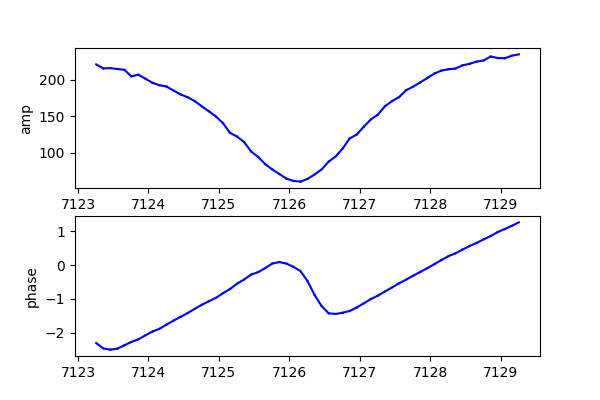

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-23 00:11:27 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality       | 
----------------------------------------------------------
|  fr  |    fc    | 7126.112 | MHz  | R²=0.9991(perfect) | 


In [8]:
cs_exp = CavityFreqSpectrum.from_experiment_context(context)

cs_exp.set_experiment_options(
    ac_prepare_time=10000,
    add_pi_pulse=False,
#     simulator_data_path='../scripts/simulator/data/CavityFreqSpectrum/',
    readout_power=-40,
)

cs_exp.set_analysis_options(
    is_plot=True,
    quality_bounds=[0.98, 0.95, 0.85]
)

cs_exp.run()

### 查看实验结果

In [28]:
pd.DataFrame(cs_exp.analysis.show_results())

,name,value,unit,extra,quality
0,fc,7126.654,MHz,{},R²=0.9988(perfect)


### 查看实验结果图

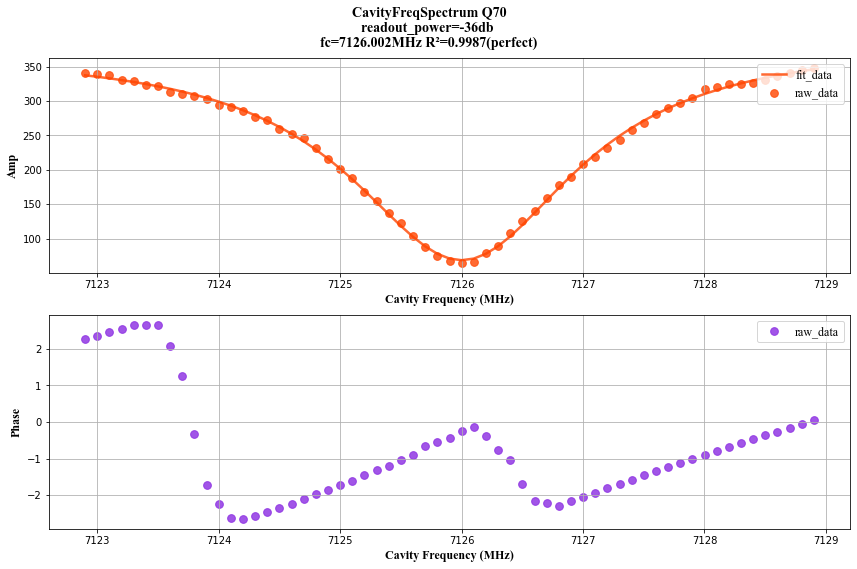

In [15]:
cs_exp.analysis.drawer.figure

### 判断结果质量并更新数据库

In [9]:
if cs_exp.analysis.quality.descriptor in [Quality.perfect, Quality.normal]:
    qubit.probe_freq = cs_exp.analysis.results.fr.value
    qubit.probe_power = cs_exp.experiment_options.readout_power
    pyqlog.info(f'Update {qubit} probe_freq {qubit.probe_freq}MHz, probe_power {qubit.probe_power}db')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-23 00:11:35 |   INFO   | Update Qubit(bit=70) probe_freq 7126.112MHz, probe_power -40db
2022-12-23 00:11:35 |  UPDATE  | Save q70 to data service success.


### 查询比特参数信息，检查是否更新成功

In [20]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7126.002,MHz,None
1,probe_power,-36.000,db,None


In [15]:
qubit.z_flux_channel
# qubit.save_data()

21

## QubitSpecturm

### 大范围能谱粗扫实验

2022-12-15 11:46:16 |   EXP    | QubitSpectrum register success, id 639a9888f47baa0f116d7e8e
2022-12-15 11:46:16 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitSpectrum\q68\2022-12-15\11.46.15\


<IPython.core.display.Javascript object>


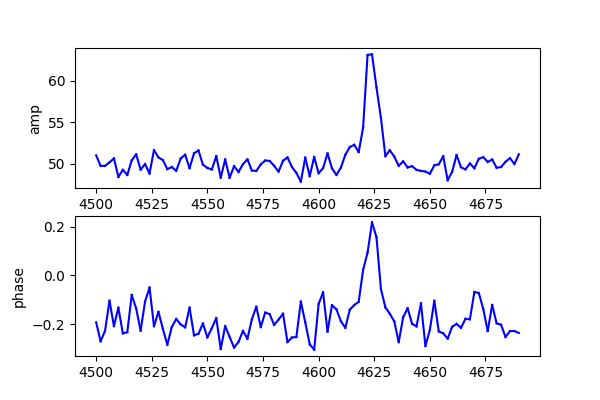

  0%|          | 0/96 [00:00<?, ?it/s]

2022-12-15 11:47:37 |  RESULT  | Experiment results as follow:
| name  | describe |  value   | unit |      quality       | 
-----------------------------------------------------------
| peaks |  peaks   | [4623.0] | MHz  | SNR=2.697(perfect) | 


In [11]:
qs_exp = QubitSpectrum.from_experiment_context(context)

qs_exp.set_experiment_options(
    ac_prepare_time=10000,
    freq_list=qarange(4000, 4050, 2),
    drive_power=-40,
    z_amp=None,
    use_square=True,
    band_width=10,
    fine_flag=False,
#     simulator_data_path='../scripts/simulator/data/QubitSpectrum/5000Mhz/rough/',
)

qs_exp.set_analysis_options(
    snr_bounds=1.5,
    quality_bounds=[0.8, 0.6, 0.5],
    is_plot=True,
)

qs_exp.run()

### 查看实验结果

In [33]:
pd.DataFrame(qs_exp.analysis.show_results())

,name,value,unit,extra,quality
0,dips,[4796.0],MHz,{},SNR=1.624(perfect)


### 查看脉冲时序图

In [ ]:
qs_exp.jupyter_schedule()

### 查看实验结果图

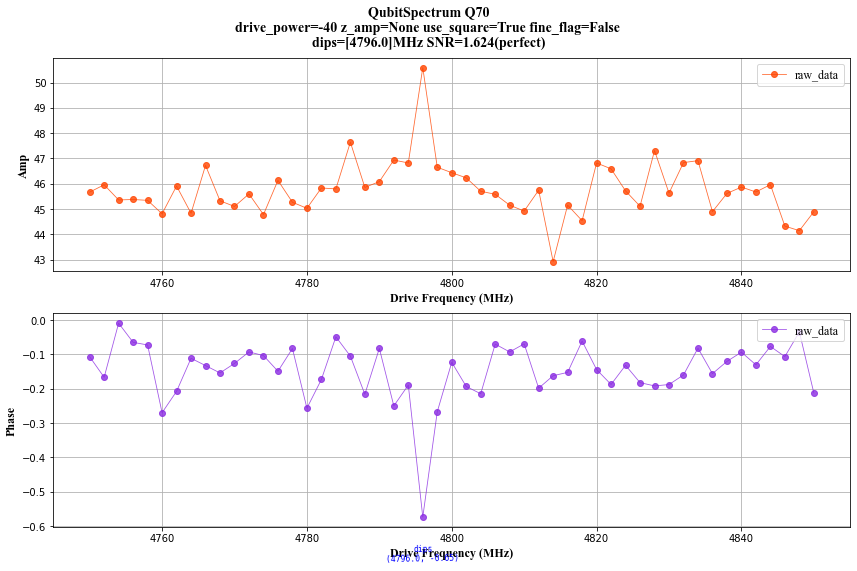

In [35]:
qs_exp.analysis.drawer.figure

### 比特能谱细扫实验

2022-12-23 00:12:02 |   EXP    | QubitSpectrum register success, id 63a481d2cb15ce0ce2c75bd6
2022-12-23 00:12:02 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitSpectrum\q70\2022-12-23\00.12.01\


<IPython.core.display.Javascript object>


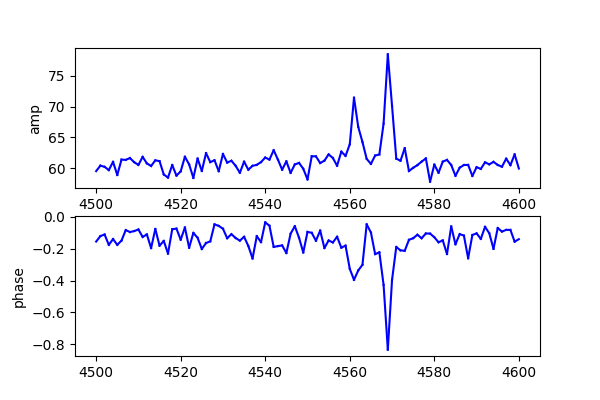

  0%|          | 0/101 [00:00<?, ?it/s]

2022-12-23 00:13:06 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality      | 
---------------------------------------------------------
| freq |   f01    | 4568.943 | MHz  | R²=0.6126(normal) | 


In [10]:
qs_exp2 = QubitSpectrum.from_experiment_context(context)

qs_exp2.set_experiment_options(
    ac_prepare_time=10000,
    freq_list=qarange(4500, 4600, 1),
    drive_power=-40,
    z_amp=None,
    use_square=True,
    band_width=10,
    fine_flag=True,
#     xpulse_params = {
#             "time": 5000,
#             "offset": 15,
#             "amp": 0.1,
#             "detune": 0,
#             "freq": 666.667
#         }
#     simulator_data_path='../scripts/simulator/data/QubitSpectrum/5000Mhz/fine/'
)

qs_exp2.set_analysis_options(
    snr_bounds=1.5,
    quality_bounds=[0.8, 0.6, 0.5],
    is_plot=True,
)

qs_exp2.run()

In [61]:
qubit.XYwave.baseband_freq

566.667

### 查看实验结果

In [18]:
pd.DataFrame(qs_exp2.analysis.show_results())

,name,value,unit,extra,quality
0,f01,4624.248,MHz,{},R²=0.7994(normal)


### 查看实验结果图

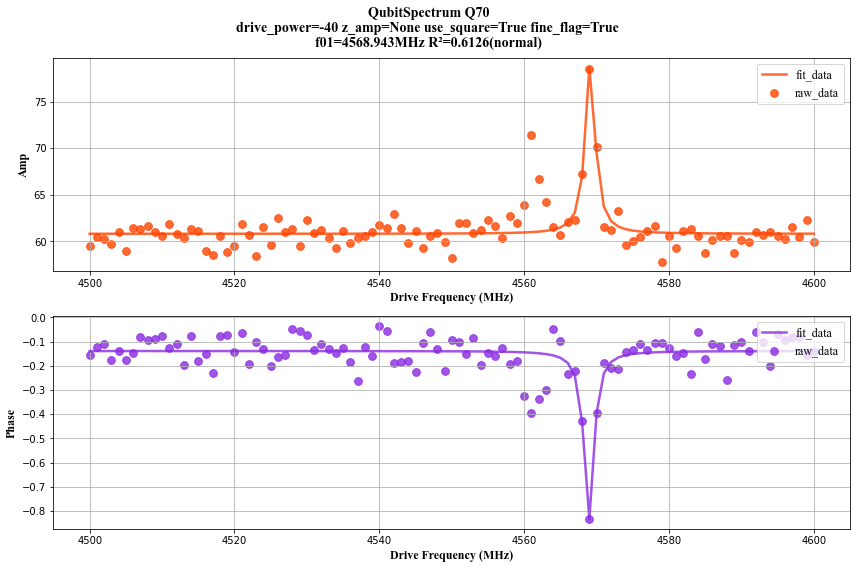

In [11]:
qs_exp2.analysis.drawer.figure

In [12]:
qs_exp2.analysis.results.freq.value

4568.943

In [91]:
qubit.XYwave.Xpi = 0.7
qubit.save_data()

2022-11-23 23:43:54 |  UPDATE  | Save q70 to data service success.


## RabiScanWidth

扫描 `Drag` 的脉冲宽度，通过其振荡规律判断比特频率是否正确

2022-12-15 23:50:43 |   EXP    | RabiScanWidth register success, id 639b42530cc00efc56bac17f
2022-12-15 23:50:43 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\RabiScanWidth\q69\2022-12-15\23.50.39\


<IPython.core.display.Javascript object>


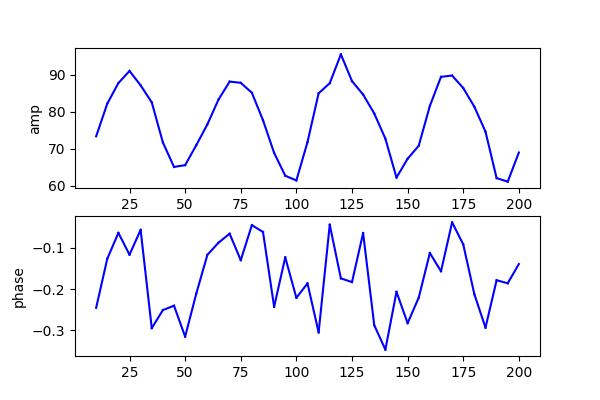

  0%|          | 0/39 [00:00<?, ?it/s]

'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
2022-12-15 23:52:27 |  RESULT  | Experiment results as follow:
|    name     |  describe   | value | unit |      quality       | 
-----------------------------------------------------------------
| oscillating | oscillating | True  | None | R²=0.946(abnormal) | 


In [18]:
rsw = RabiScanWidth.from_experiment_context(context)

rsw.set_experiment_options(
    ac_prepare_time=10000,
    drive_freq=4012.949,
    drive_power=-10,
    widths = qarange(10, 200, 5)
#     simulator_data_path='../scripts/simulator/data/RabiScanWidth'
)

rsw.run()

### 检查脉冲时序

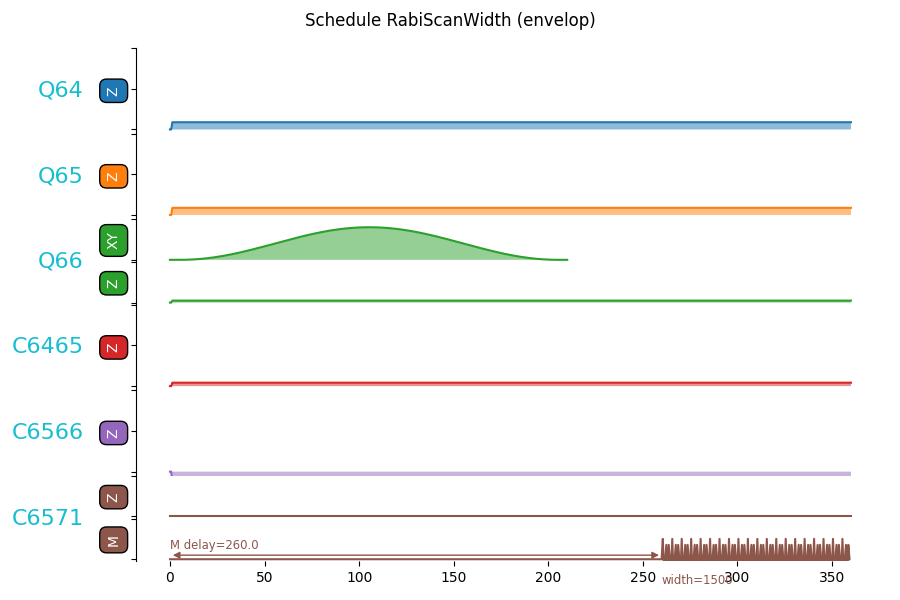

In [101]:
rsw.jupyter_schedule()

### 查看实验结果

In [40]:
pd.DataFrame(rsw.analysis.show_results())

,name,value,unit,extra,quality
0,oscillating,True,None,{},R²=0.9815(perfect)


### 查看实验结果图

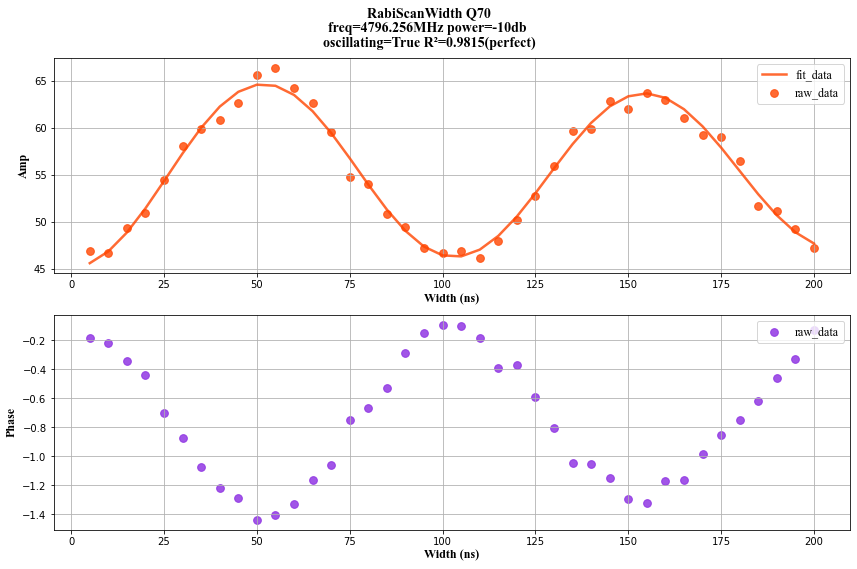

In [41]:
rsw.analysis.drawer.figure

### 根据能谱和 RabiWidth 判断是否更新比特频率

In [19]:
qs_quality = qs_exp2.analysis.quality.descriptor
oscillating = rsw.analysis.results.oscillating.value

if qs_quality in [Quality.perfect, Quality.normal] and oscillating:
    qubit.drive_freq = qs_exp2.analysis.results.freq.value
    qubit.drive_power = qs_exp2.experiment_options.drive_power
    pyqlog.info(f'Update {qubit} drive_freq {qubit.drive_freq}MHz, drive_power {qubit.drive_power}db')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-15 23:52:41 |   INFO   | Update Qubit(bit=69) drive_freq 4012.949MHz, drive_power -40db
2022-12-15 23:52:41 |  UPDATE  | Save q69 to data service success.


In [13]:
qubit.drive_freq = 4568.943
qubit.save_data()

2022-12-23 00:17:35 |  UPDATE  | Save q70 to data service success.


### 检索比特参数

In [77]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7126.078,MHz,None
1,probe_power,-28.000,db,None
2,drive_freq,4619.365,MHz,None
3,drive_power,-13.000,db,None


In [16]:
qubit.XYwave.time = 80
# qubit.drive_freq = 4794.108
qubit.save_data()

2022-12-23 00:27:45 |  UPDATE  | Save q70 to data service success.


In [49]:
context.qubit.XYwave.time

50

## XpiDetection

XpiDetune 实验是对 RabiScanAmp 实验的封装， 扫描 `Drag` 幅值，粗测 `X` 门幅值

2022-12-23 00:30:43 |   EXP    | The expect_value is 0.7.
2022-12-23 00:30:43 |   EXP    | The max test time is 5.
2022-12-23 00:30:43 |   EXP    | RabiScanAmp count 0, drive_power -10
2022-12-23 00:30:48 |   EXP    | RabiScanAmp register success, id 63a48638cb15ce0ce2c75ce2
2022-12-23 00:30:48 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\XpiDetection\q70\2022-12-23\00.30.43\RabiScanAmp\00-30-43-count=0-drive_power=-10\


<IPython.core.display.Javascript object>


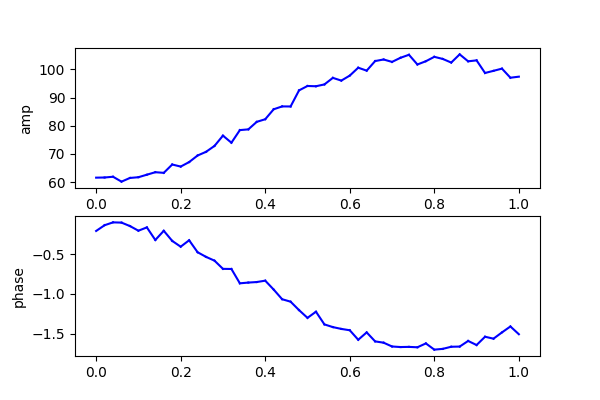

  0%|          | 0/51 [00:00<?, ?it/s]

2022-12-23 00:31:22 |  RESULT  | Experiment results as follow:
|    name     | describe | value | unit |      quality       | 
--------------------------------------------------------------
| drive_power |    dp    |  -10  |  db  | R²=0.9945(perfect) | 
|     Xpi     |  X-amp   | 0.78  |  V   | R²=0.9945(perfect) | 
2022-12-23 00:31:22 |  RESULT  | Success, Xpi 0.78, drive_power -10


In [19]:
xd = XpiDetection.from_experiment_context(context)

xd.set_experiment_options(
    amps=qarange(0, 1, 0.02),
    drive_power=-10,
    name="Xpi",
#     simulator_data_path='../scripts/simulator/data/XpiDetection/'
)
xd.child_experiment.set_experiment_options(
    ac_prepare_time=10000,
)


xd.run()

### 查看实验结果

In [46]:
pd.DataFrame(xd.analysis.show_results())

,name,value,unit,extra,quality
0,dp,-10.00,db,{},R²=0.9875(perfect)
1,X-amp,0.82,V,{},R²=0.9875(perfect)


### 查看实验结果图

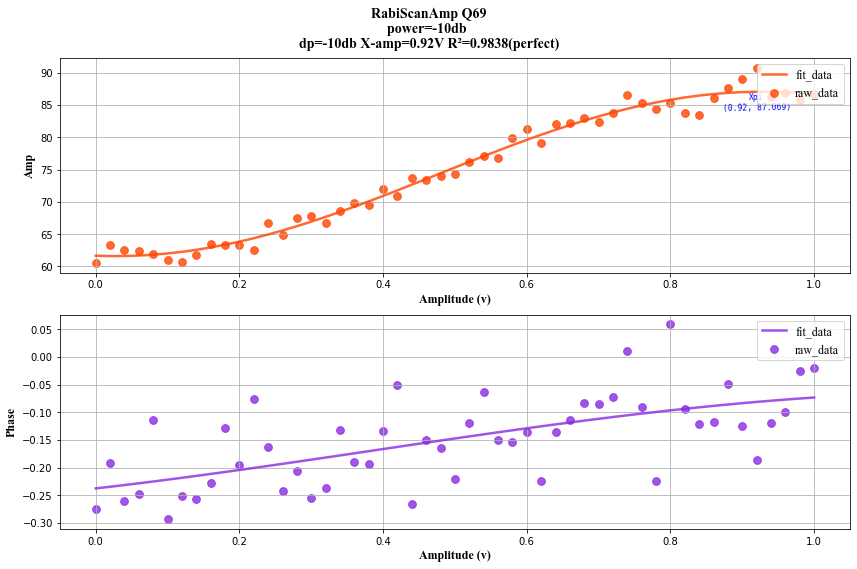

In [22]:
xd.analysis.drawer.figure

### 检查实验质量并更新比特参数

In [20]:
xd_quality = xd.analysis.quality.descriptor
Xpi = xd.analysis.results.Xpi.value
drive_power = xd.analysis.results.drive_power.value

if xd_quality in [Quality.perfect, Quality.normal]:
    qubit.XYwave.Xpi = Xpi
    qubit.XYwave.Xpi2 = round(Xpi / 2, 3)
    qubit.drive_power = drive_power
    pyqlog.info(f'Update {qubit} Xpi {qubit.XYwave.Xpi}v, Xpi2 {qubit.XYwave.Xpi2}v, drive_power {qubit.drive_power}db')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-23 00:31:58 |   INFO   | Update Qubit(bit=70) Xpi 0.78v, Xpi2 0.39v, drive_power -10db
2022-12-23 00:31:58 |  UPDATE  | Save q70 to data service success.


In [24]:
Xpi = 0.66
qubit.XYwave.Xpi = Xpi
qubit.XYwave.Xpi2 = round(Xpi / 2, 3)
qubit.drive_power = -12
qubit.save_data()

2022-12-02 17:19:58 |  UPDATE  | Save q70 to data service success.


### 检索比特参数，检查是否更新成功

In [60]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7125.914,MHz,None
1,probe_power,-30.000,db,None
2,drive_freq,4615.063,MHz,None
3,drive_power,-19.900,db,None
4,XYwave.Xpi,0.700,v,None
5,XYwave.Xpi2,0.350,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


## ReadoutFreqCalibrate

读取频率优化，此实验执行两次腔能谱实验，第一次不加驱动脉冲测量，第二次加驱动脉冲测量，通过分析两个子实验选择合适的读取频率。

In [35]:
qubit.probe_power = -38
qubit.save_data()

2022-12-16 00:05:49 |  UPDATE  | Save q69 to data service success.


2022-12-23 00:32:03 |   EXP    | CavityFreqSpectrum register success, id 63a48683cb15ce0ce2c75ce4
2022-12-23 00:32:03 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutFreqCalibrate\q70\2022-12-23\00.32.03\CavityFreqSpectrum\00-32-03-xy_pulse amp=0\


<IPython.core.display.Javascript object>


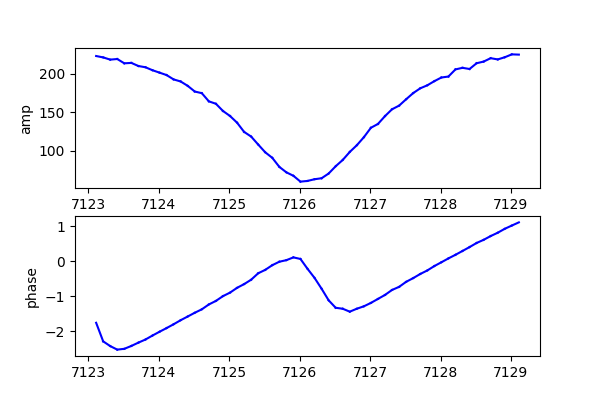

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-23 00:32:43 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality       | 
----------------------------------------------------------
|  fr  |    fc    | 7126.116 | MHz  | R²=0.9993(perfect) | 
2022-12-23 00:32:43 |   EXP    | CavityFreqSpectrum register success, id 63a486abcb15ce0ce2c75ce6
2022-12-23 00:32:43 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutFreqCalibrate\q70\2022-12-23\00.32.03\CavityFreqSpectrum\00-32-43-xy_pulse amp=0.78\


<IPython.core.display.Javascript object>


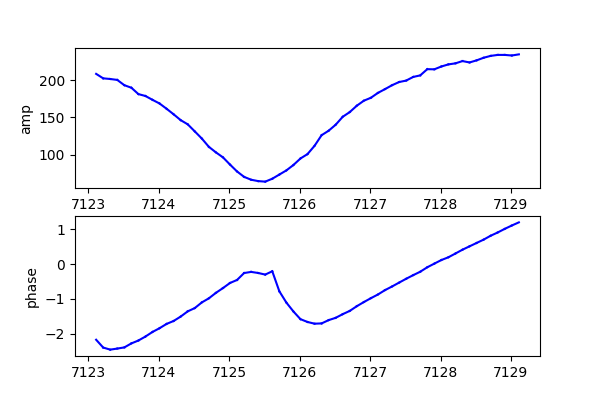

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-23 00:33:24 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality       | 
----------------------------------------------------------
|  fr  |    fc    | 7125.461 | MHz  | R²=0.9993(perfect) | 
2022-12-23 00:33:24 |  RESULT  | Experiment results as follow:
|      name       |   describe   |       value        | unit | quality | 
------------------------------------------------------------------------
|       fr        |  CavityFreq  |      7125.789      | MHz  |  None   | 
|     mean_fr     |     Mean     |      7125.789      | MHz  |  None   | 
|   distance_fr   |   Distance   |      7126.012      | MHz  |  None   | 
| intersection_fr | Intersection |      7125.712      | MHz  |  None   | 
|    distance     | max amp gap  | 115.82401939250636 |  v   |  None   | 
|      shift      |    shift     |        True        | None |  None   | 


In [21]:
rfc = ReadoutFreqCalibrate.from_experiment_context(context)

rfc.set_experiment_options(
#     simulator_data_path='../scripts/simulator/data/ReadoutFreqCalibrate/'
)

rfc.set_analysis_options(
    distance_flag=False, diff_threshold=0.1
)

rfc.child_experiment.set_experiment_options(
    ac_prepare_time=10000,
)

rfc.child_experiment.set_analysis_options(
    quality_bounds=[0.98, 0.95, 0.85], is_plot=True
)

rfc.run()

### 查看实验结果

In [24]:
pd.DataFrame(rfc.analysis.show_results())

,name,value,unit,extra,quality
0,CavityFreq,7125.989,MHz,{},None
1,Mean,7125.989,MHz,{},None
2,Distance,7126.556,MHz,{},None
3,Intersection,7125.856,MHz,{},None
4,max amp gap,59.606364,v,"{'out_flag': False, 'value': array([44.84726533, 56.18723846, 55.14291825, 53.5700713 , 51.64597582, 37.8344856 , 30.78637474, 37.96250174, 13.70481026, 18.00020796, 21.32395372, 30.38133515, 24.23792611, 28.7181158 , 30.33353126, 29.61670126, 35.1996604 , 40.69871 , 39.59711454, 42.6578372 , 42.09339747, 33.67078633, 36.7685736 , 32.15731291, 28.28284684, 23.4555966 , 10.92720655, 5.47504288, 12.0222821 , 21.24754003, 37.04629268, 43.84021598, 57.44887126, 59.60636433, 51.7675272 , 42.33593018, 32.55799593, 27.43287867, 19.79339191, 19.0189728 , 17.65271879, 18.65062815, 20.21783184, 18.41780453, 15.54266929, 17.36913964, 17.30349177, 17.35712012, 11.62460058, 16.06595393, 12.69672452, 11.79856155, 9.91355824, 10.19087743, 10.21197598, 9.39300095, 8.04080005, 10.18352128, 5.5483647 , 11.33566101, 3.70590286])}",None
5,shift,True,None,{},None


### 查看实验结果图

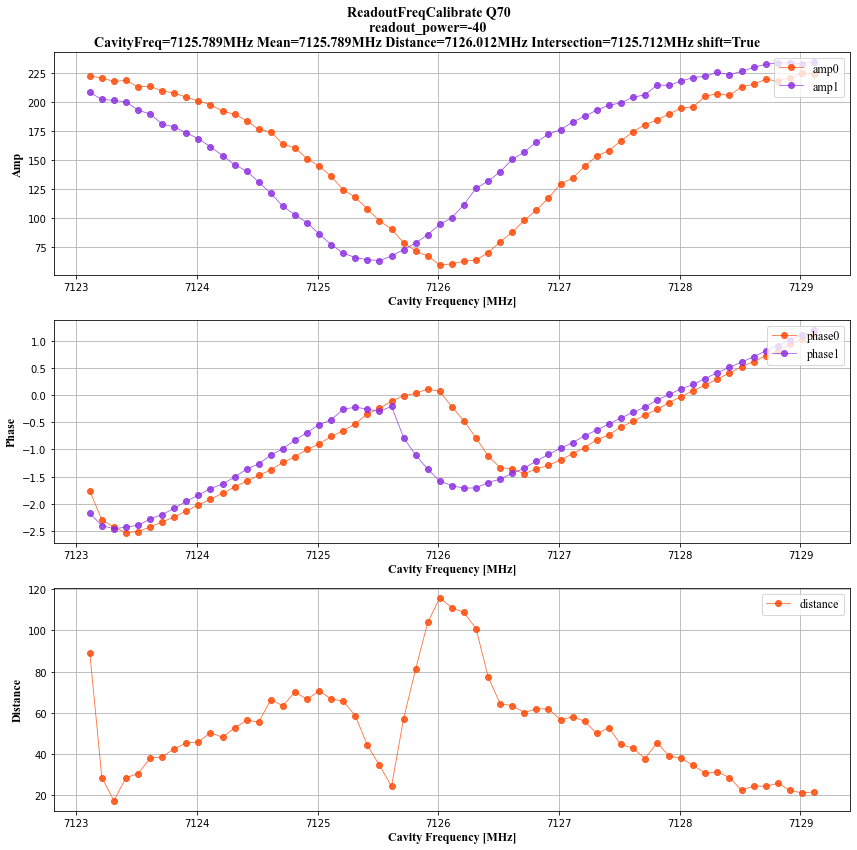

In [22]:
rfc.analysis.drawer.figure

### 更新比特参数

In [23]:
qubit.probe_freq = rfc.analysis.results.fr.value
qubit.save_data()

2022-12-23 00:34:10 |  UPDATE  | Save q70 to data service success.


In [53]:
rfc.analysis.results.keys()

dict_keys(['fr', 'mean_fr', 'distance_fr', 'intersection_fr', 'distance', 'shift'])

### 检索比特参数信息

In [14]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7125.956,MHz,None
1,probe_power,-36.000,db,None
2,drive_freq,4619.874,MHz,None
3,drive_power,-10.000,db,None
4,XYwave.Xpi,0.880,v,None
5,XYwave.Xpi2,0.440,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


## ReadoutPowerCalibrate

读取功率优化，此实验固定其他参数，扫描读取频率执行 `SingleShot` 实验，找到 `IQ` 数据分的最开下的读取功率

In [24]:
rpc = ReadoutPowerCalibrate.from_experiment_context(context)

simulator_data_path = []
power_list = qarange(-40, -26, 2)

rpc.set_experiment_options(
    sweep_list=power_list,
#     simulator_data_path='../scripts/simulator/data/ReadoutPowerCalibrate/'
)

rpc.set_analysis_options(
    fidelity_threshold=[0.8, 0.5],
    outlier=0.03,
)

rpc.child_experiment.set_experiment_options(
    repeat=5000,
    ac_prepare_time=8000,
)

rpc.child_experiment.set_analysis_options(
    quality_bounds=[2, 0.85, 0.7, 0.011], is_plot=True, method="GMM"
)

rpc.run()

2022-12-23 00:34:13 |   EXP    | Run SingleShot probe_power: -40
2022-12-23 00:34:14 |   EXP    | SingleShot register success, id 63a48706cb15ce0ce2c75cf8
2022-12-23 00:34:14 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-23\00.34.13\SingleShot\00-34-13-probe_power=-40\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-23 00:34:21 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |   quality    | 
---------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.8218, 0.7828] AVE=0.8023 OL=0.0079 | None | {'q70': bad} | 
2022-12-23 00:34:21 |   EXP    | Run SingleShot probe_power: -38
2022-12-23 00:34:21 |   EXP    | SingleShot register success, id 63a4870dcb15ce0ce2c75d0a
2022-12-23 00:34:21 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-23\00.34.13\SingleShot\00-34-21-probe_power=-38\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-23 00:34:28 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |     quality     | 
-----------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.893, 0.8182] AVE=0.8556 OL=0.0077 | None | {'q70': normal} | 
2022-12-23 00:34:28 |   EXP    | Run SingleShot probe_power: -36
2022-12-23 00:34:29 |   EXP    | SingleShot register success, id 63a48715cb15ce0ce2c75d1c
2022-12-23 00:34:29 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-23\00.34.13\SingleShot\00-34-28-probe_power=-36\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-23 00:34:36 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |     quality     | 
-----------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.927, 0.8454] AVE=0.8862 OL=0.0081 | None | {'q70': normal} | 
2022-12-23 00:34:36 |   EXP    | Run SingleShot probe_power: -34
2022-12-23 00:34:36 |   EXP    | SingleShot register success, id 63a4871ccb15ce0ce2c75d2e
2022-12-23 00:34:36 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-23\00.34.13\SingleShot\00-34-36-probe_power=-34\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-23 00:34:44 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |     quality     | 
------------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.9624, 0.8594] AVE=0.9109 OL=0.0082 | None | {'q70': normal} | 
2022-12-23 00:34:44 |   EXP    | Run SingleShot probe_power: -32
2022-12-23 00:34:44 |   EXP    | SingleShot register success, id 63a48724cb15ce0ce2c75d40
2022-12-23 00:34:44 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-23\00.34.13\SingleShot\00-34-44-probe_power=-32\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-23 00:34:51 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |     quality     | 
------------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.9804, 0.8644] AVE=0.9224 OL=0.0086 | None | {'q70': normal} | 
2022-12-23 00:34:51 |   EXP    | Run SingleShot probe_power: -30
2022-12-23 00:34:51 |   EXP    | SingleShot register success, id 63a4872bcb15ce0ce2c75d52
2022-12-23 00:34:51 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-23\00.34.13\SingleShot\00-34-51-probe_power=-30\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-23 00:34:59 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |     quality     | 
-----------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.9884, 0.856] AVE=0.9222 OL=0.0084 | None | {'q70': normal} | 
2022-12-23 00:34:59 |   EXP    | Run SingleShot probe_power: -28
2022-12-23 00:34:59 |   EXP    | SingleShot register success, id 63a48733cb15ce0ce2c75d64
2022-12-23 00:34:59 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-23\00.34.13\SingleShot\00-34-59-probe_power=-28\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-23 00:35:06 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |   quality    | 
---------------------------------------------------------------------------------------------
| q70  |   q70    | K=3 F(0, 1)=[0.9844, 0.8706] AVE=0.9275 OL=0.0165 | None | {'q70': bad} | 
2022-12-23 00:35:06 |   EXP    | Run SingleShot probe_power: -26
2022-12-23 00:35:06 |   EXP    | SingleShot register success, id 63a4873acb15ce0ce2c75d76
2022-12-23 00:35:06 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-23\00.34.13\SingleShot\00-35-06-probe_power=-26\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-23 00:35:14 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |   quality    | 
--------------------------------------------------------------------------------------------
| q70  |   q70    | K=3 F(0, 1)=[0.988, 0.6806] AVE=0.8343 OL=0.0096 | None | {'q70': bad} | 
2022-12-23 00:35:14 |  RESULT  | Experiment results as follow:
|      name      |    describe    | value | unit | quality | 
------------------------------------------------------------
| optimize_field | optimize_field |  -32  | None |  None   | 
| fidelity_flag  | fidelity_flag  | True  | None |  None   | 
|  outlier_flag  |  outlier_flag  | True  | None |  None   | 
|     status     |     status     |   0   | None |  None   | 
2022-12-23 00:35:14 |   FLOW   | Readout Power Calibrate q70 Pass! Readout Power: -32


### 查询实验结果

In [51]:
pd.DataFrame(rpc.analysis.show_results())

,name,value,unit,extra,quality
0,optimize_field,-34,None,{},None
1,fidelity_flag,True,None,{},None
2,outlier_flag,True,None,{},None
3,status,0,None,{},None


### 查询实验结果图

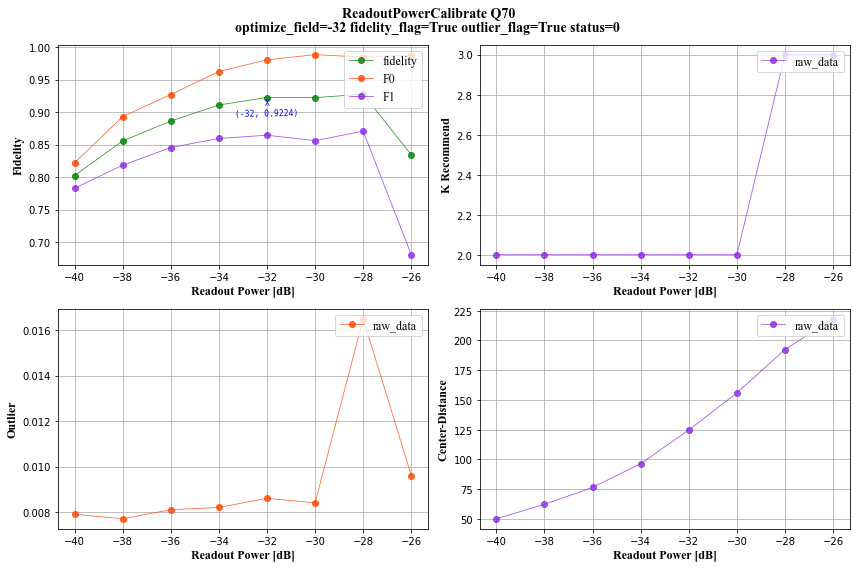

In [25]:
rpc.analysis.drawer.figure

### 查询子实验结果图

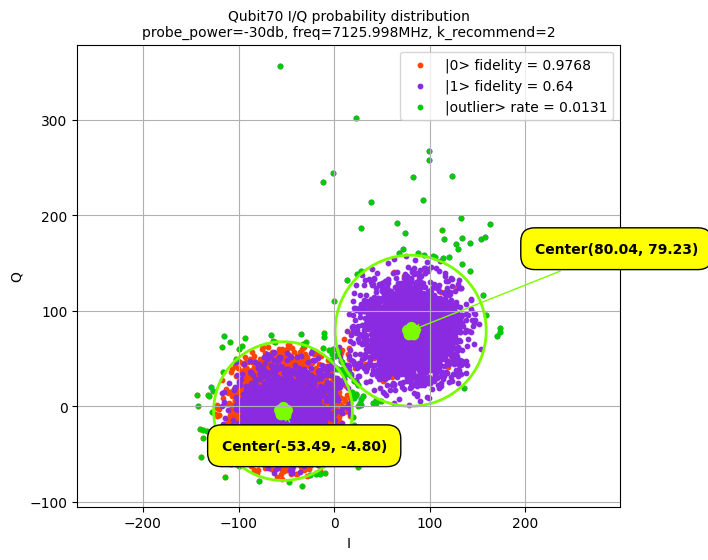

In [25]:
rpc.component_experiment(index=-3).analysis.drawer.figure

### 更新比特参数

In [26]:
qubit.probe_power = -32
qubit.save_data()

2022-12-23 00:35:56 |  UPDATE  | Save q70 to data service success.


In [83]:
type(rpc.analysis.results.optimize_field.value)

numpy.int32

### 检索比特参数

In [7]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7125.989,MHz,None
1,probe_power,-36.000,db,None
2,drive_freq,4623.719,MHz,None
3,drive_power,-10.000,db,None
4,XYwave.Xpi,0.960,v,None
5,XYwave.Xpi2,0.480,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


## SampleWidthOptimize

采样宽度优化，此实验固定其他参数，扫描采集宽度执行 `SingleShot` 实验，找到 `IQ` 数据分的最开下的采集宽度

In [ ]:
swo = SampleWidthOptimize.from_experiment_context(context)

simulator_data_path = []
width_list = qarange(800, 2500, 100)

swo.set_experiment_options(
    sweep_list=width_list,
    simulator_data_path='../scripts/simulator/data/SampleWidthOptimize/'
)

swo.set_analysis_options(
    fidelity_threshold=[0.9, 0.8],
    outlier=0.011,
    distance_flag=False,
)

swo.child_experiment.set_experiment_options(repeat=5000)

swo.child_experiment.set_analysis_options(
    quality_bounds=[2, 0.85, 0.7, 0.011], is_plot=True, method="GMM"
)

swo.run()

### 查询实验结果

In [ ]:
pd.DataFrame(swo.analysis.show_results())

### 查询子实验结果图

In [ ]:
swo.component_experiment(5).analysis.drawer.figure

### 查询实验结果图

In [ ]:
swo.analysis.drawer.figure

### 更新比特参数

In [ ]:
qubit.sample_width = 1300
qubit.save_data()

### 检索比特信息

In [ ]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave', 'sample_width']
    )
)

## SingleShot

获取 `IQ` 分类器

In [60]:
context.discriminators = None


In [9]:
ss = SingleShot.from_experiment_context(context)

ss.set_experiment_options(
    ac_prepare_time=10000,
    repeat=5000,
    is_check=False,
    save_bin=True,
#     simulator_data_path='../scripts/simulator/data/SingleShot/'
)

ss.set_analysis_options(
    method="GMM", quality_bounds=[2, 0.80, 0.65, 0.011], is_plot=True
)

ss.run()

2022-12-23 01:06:07 |   EXP    | SingleShot register success, id 63a48e7ffbb1f1cd507a9421
2022-12-23 01:06:07 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\SingleShot\q70\2022-12-23\01.06.06\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-23 01:06:14 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |     quality     | 
-----------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.9738, 0.8502] AVE=0.912 OL=0.0094 | None | {'q70': normal} | 
2022-12-23 01:06:14 |  UPDATE  | Save q70.bin to data service success.


### 查询脉冲时序图

In [ ]:
ss.jupyter_schedule()

### 查询实验结果

In [130]:
pd.DataFrame(ss.analysis.show_results())

,name,value,unit,extra,quality
0,q70,K=2 F0=0.9512 F1=0.8274 AVE=0.8893 OL=0.0102,None,{},{'q70': normal}


### 查询实验结果图

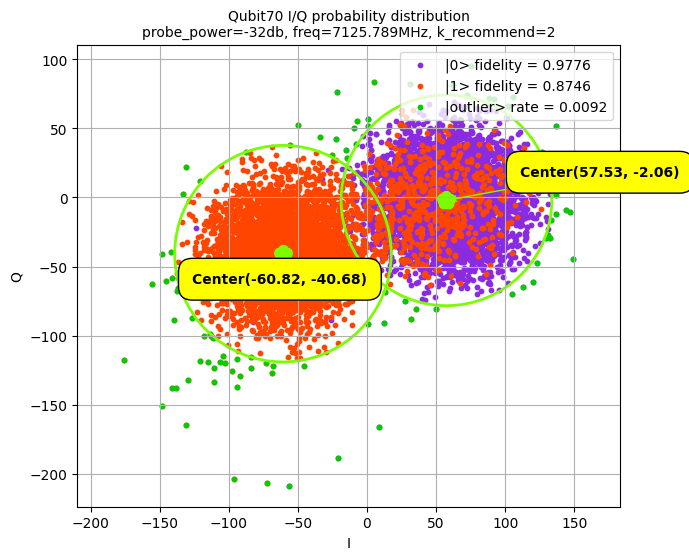

In [29]:
ss.analysis.drawer.figure

### 为当前实验环境绑定比特判据

In [10]:
context.configure_dcm(q_name)

IQdiscriminator<center=[[ 57.42247221  -2.832725  ]
 [-59.81881217 -39.75926355]]>

y = \frac{A_2\cdot kappa_2}{\pi\cdot ((f-f_2)^2 + {kappa_2}^2)} +
         \frac{A\cdot kappa}{\pi\cdot ((f-f_0)^2 + {kappa}^2)}

### 检索当前实验环境中的系统参数

In [133]:
pd.DataFrame(context.context_table())

,parameter,object,count
0,config,F:\MonsterTest_QT8013\conf\config.conf,
1,qubits,[Qubit(bit=70)],1
2,couplers,[],0
3,discriminators,None,0
4,compensates,"{Qubit(bit=64): PulseCorrectionQ64, Qubit(bit=65): PulseCorrectionQ65, Qubit(bit=69): PulseCorrectionQ69, Qubit(bit=71): PulseCorrectionQ71, Qubit(bit=72): PulseCorrectionQ72, Coupler(bit=6470, driveQ64, probeQ70): PulseCorrectionC6470, Coupler(bit=6571, driveQ65, probeQ71): PulseCorrectionC6571, Coupler(bit=6970, driveQ69, probeQ70): PulseCorrectionC6970, Coupler(bit=7071, driveQ70, probeQ71): PulseCorrectionC7071, Coupler(bit=7172, driveQ71, probeQ72): PulseCorrectionC7172, Qubit(bit=70): PulseCorrectionQ70}",11
5,working_dc,True,
6,crosstalk_dict,True,


## DriveFreqCalibrate


驱动频率校准实验，该实验通过执行两次 `Ramsey` 实验，精细校准比特的驱动频率

In [ ]:
set_subanalysis_options(is_plot=True)

2022-12-23 00:37:59 |   EXP    | Ramsey register success, id 63a487e7cb15ce0ce2c75dd9
2022-12-23 00:37:59 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitFreqCalibration\q70\2022-12-23\00.37.52\Ramsey\00-37-52-fringe=80MHz\


<IPython.core.display.Javascript object>


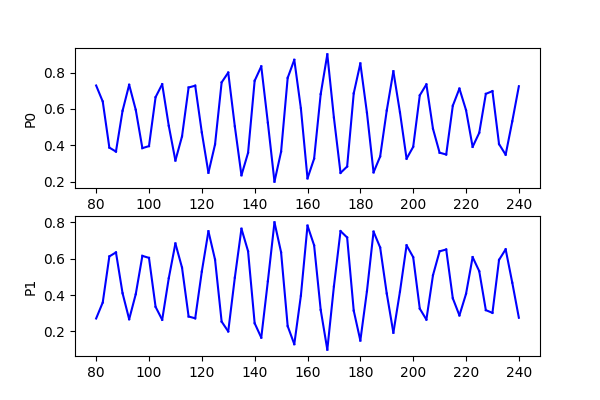

  0%|          | 0/65 [00:00<?, ?it/s]

2022-12-23 00:38:43 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |       quality       | 
-----------------------------------------------------------
| freq |   fosc   | 80.19117 | MHz  | R²=0.8919(abnormal) | 
2022-12-23 00:38:50 |   EXP    | Ramsey register success, id 63a4881acb15ce0ce2c75e2a
2022-12-23 00:38:50 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitFreqCalibration\q70\2022-12-23\00.37.52\Ramsey\00-38-43-fringe=-80MHz\


<IPython.core.display.Javascript object>


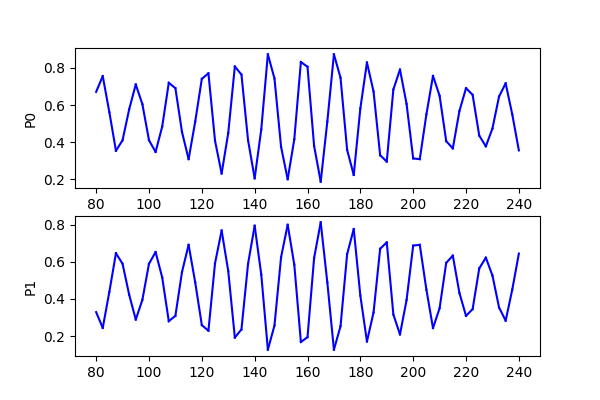

  0%|          | 0/65 [00:00<?, ?it/s]

2022-12-23 00:39:34 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |       quality       | 
-----------------------------------------------------------
| freq |   fosc   | 79.85323 | MHz  | R²=0.8666(abnormal) | 
2022-12-23 00:39:34 |  RESULT  | Experiment results as follow:
|      name       |    describe     |                          value                           | unit |   quality   | 
---------------------------------------------------------------------------------------------------------------------
|   f01_records   |   f01_records   | [4408.75183, 4569.0897700000005, 4569.13417, 4728.79623] | MHz  | Quality.bad | 
|       f01       |       f01       |                         4569.112                         | MHz  | Quality.bad | 
| minimum_f01_gap | minimum_f01_gap |                          0.044                           | MHz  | Quality.bad | 


In [31]:
qfc = QubitFreqCalibration.from_experiment_context(context)

qfc.set_experiment_options(
    fringes=[80, -80],
    delays=qarange(80, 240, 2.5),
#     simulator_data_path='../scripts/simulator/data/QubitFreqCalibration/',
    show_result=True,
    
    
)

qfc.set_analysis_options(freq_gap_threshold=0.2,
                         is_plot=True)

qfc.child_experiment.set_analysis_options(
    quality_bounds=[0.98, 0.9, 0.8],
    is_plot=True
)
qfc.child_experiment.set_experiment_options(is_dynamic=1,ac_prepare_time=10000,)
qfc.run()

### 检索子实验的脉冲时序图

In [ ]:
qfc.component_experiment(index=0).jupyter_schedule()

### 查询实验结果图

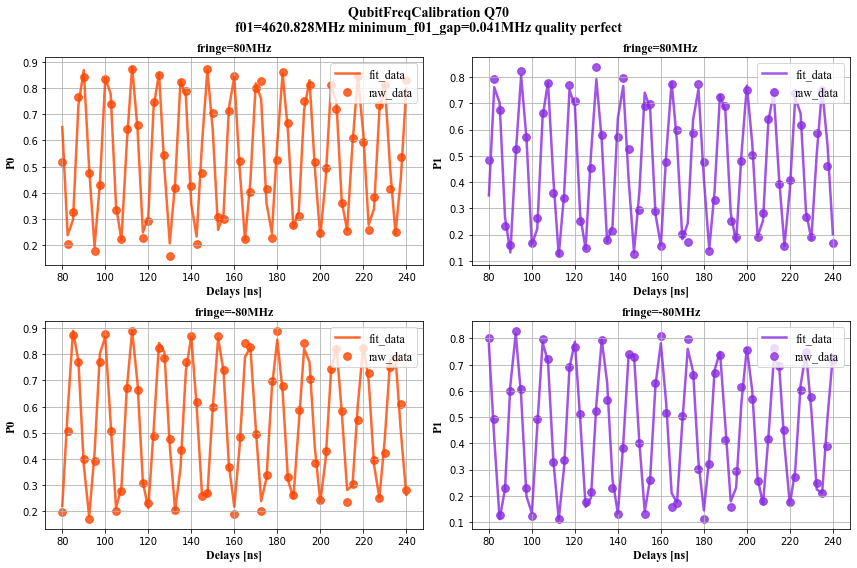

In [114]:
qfc.analysis.drawer.figure

### 更新比特参数

In [67]:
qfc_quality = qfc.analysis.quality.value
f01 = qfc.analysis.results.f01.value
if qfc_quality == Quality.perfect:
    qubit.drive_freq = f01
    pyqlog.info(f'Update {qubit} drive_freq {qubit.drive_freq}MHz!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-22 01:08:54 |   INFO   | Update Qubit(bit=69) drive_freq 4017.46MHz!
2022-12-22 01:08:54 |  UPDATE  | Save q69 to data service success.


In [32]:
qubit.drive_freq = 4569.112
qubit.save_data()

2022-12-23 00:40:02 |  UPDATE  | Save q70 to data service success.


### 检索比特信息

In [54]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave', 'sample_width']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7125.971,MHz,None
1,probe_power,-32.000,db,None
2,drive_freq,4620.782,MHz,None
3,drive_power,-12.000,db,None
4,XYwave.Xpi,0.680,v,None
5,XYwave.Xpi2,0.340,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


## DetuneCalibration

DetuneCalibration 实验，精细校准失谐量 `detune`

2022-12-23 00:40:18 |   EXP    | theta_type: Xpi, N: 6
2022-12-23 00:40:24 |   EXP    | APE register success, id 63a48878cb15ce0ce2c75e6d
2022-12-23 00:40:24 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-23\00.40.18\APEComposite\00-40-18-RoughScan\APE\00-40-18-N=6\


<IPython.core.display.Javascript object>


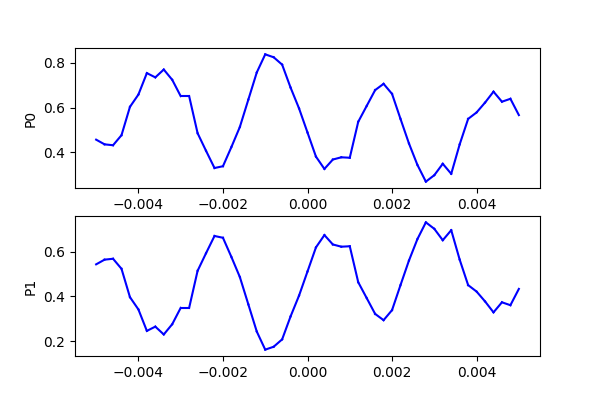

  0%|          | 0/51 [00:00<?, ?it/s]

2022-12-23 00:40:59 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                      value                       | unit |       quality       | 
---------------------------------------------------------------------------------------------------------------
|   points_0   |   points_0   |     detune peaks: [-0.0034, -0.001, 0.0018]      | None | R²=0.8319(abnormal) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.0034, -0.0008, 0.0018, 0.0044] | None | R²=0.8319(abnormal) | 
2022-12-23 00:40:59 |   EXP    | theta_type: Xpi, N: 7
2022-12-23 00:41:05 |   EXP    | APE register success, id 63a488a1cb15ce0ce2c75eb2
2022-12-23 00:41:05 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-23\00.40.18\APEComposite\00-40-18-RoughScan\APE\00-40-59-N=7\


<IPython.core.display.Javascript object>


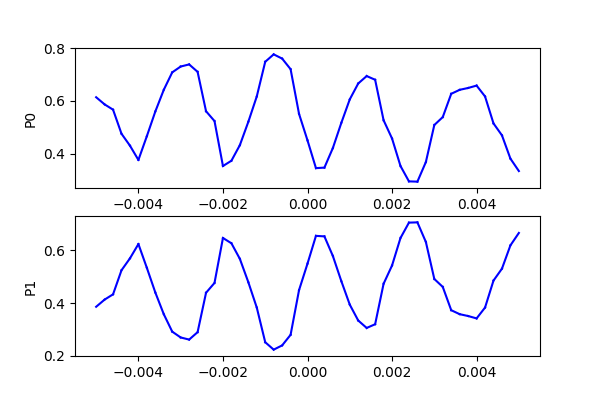

  0%|          | 0/51 [00:00<?, ?it/s]

2022-12-23 00:41:39 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                      value                      | unit |      quality       | 
-------------------------------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.0028, -0.0008, 0.0014, 0.004] | None | R²=0.866(abnormal) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.003, -0.0008, 0.0014, 0.0036] | None | R²=0.866(abnormal) | 
2022-12-23 00:41:39 |   EXP    | theta_type: Xpi, N: 8
2022-12-23 00:41:45 |   EXP    | APE register success, id 63a488c9cb15ce0ce2c75efc
2022-12-23 00:41:45 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-23\00.40.18\APEComposite\00-40-18-RoughScan\APE\00-41-39-N=8\


<IPython.core.display.Javascript object>


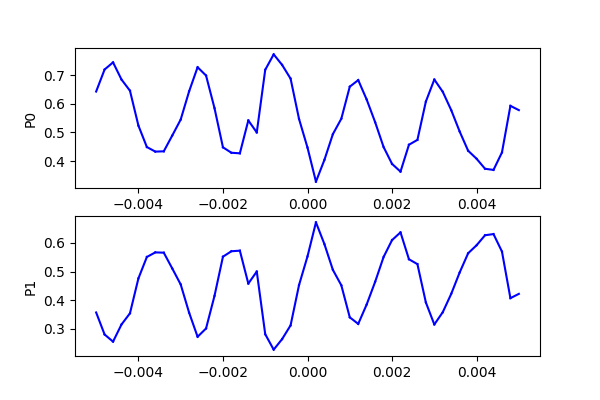

  0%|          | 0/51 [00:00<?, ?it/s]

2022-12-23 00:42:20 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                           value                           | unit |       quality       | 
------------------------------------------------------------------------------------------------------------------------
|   points_0   |   points_0   |      detune peaks: [-0.0026, -0.0008, 0.0012, 0.003]      | None | R²=0.8591(abnormal) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.0046, -0.0026, -0.0008, 0.0012, 0.0032] | None | R²=0.8591(abnormal) | 
2022-12-23 00:42:20 |   EXP    | theta_type: Xpi, N: 7
2022-12-23 00:42:23 |   EXP    | APE register success, id 63a488efcb15ce0ce2c75f2a
2022-12-23 00:42:23 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-23\00.40.18\APEComposite\00-42-20-FineScan\APE\00-42-20-N=7\


<IPython.core.display.Javascript object>


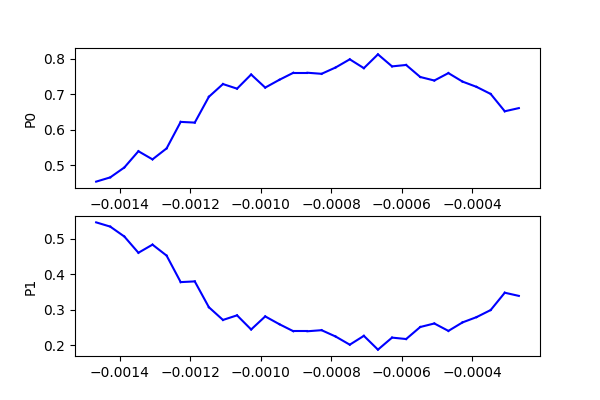

  0%|          | 0/31 [00:00<?, ?it/s]

2022-12-23 00:42:45 |  RESULT  | Experiment results as follow:
|     name     |   describe   |           value           | unit |      quality       | 
---------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.000667] | None | R²=0.9769(perfect) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.000707] | None | R²=0.9769(perfect) | 
2022-12-23 00:42:45 |   EXP    | theta_type: Xpi, N: 9
2022-12-23 00:42:48 |   EXP    | APE register success, id 63a48908cb15ce0ce2c75f5a
2022-12-23 00:42:48 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-23\00.40.18\APEComposite\00-42-20-FineScan\APE\00-42-45-N=9\


<IPython.core.display.Javascript object>


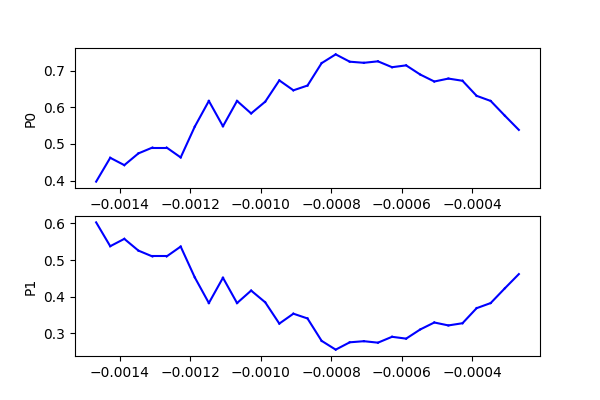

  0%|          | 0/31 [00:00<?, ?it/s]

2022-12-23 00:43:10 |  RESULT  | Experiment results as follow:
|     name     |   describe   |           value           | unit |      quality       | 
---------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.000787] | None | R²=0.9715(perfect) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.000707] | None | R²=0.9715(perfect) | 
2022-12-23 00:43:10 |  RESULT  | Experiment results as follow:
|  name  | describe | value  | unit |    quality    | 
-----------------------------------------------------
| detune |  detune  | -0.001 | GHz  | evaluate good | 


In [33]:
dec = DetuneCalibration.from_experiment_context(context)

dec.set_experiment_options(
    detune_list=qarange(-5e-3, 5.0e-3, 0.2e-3),
    rough_n_list=[6, 7, 8],
    fine_n_list=[7, 9],
    theta_type="Xpi",
    fine_precision=0.2e-3,
#     simulator_data_path='../scripts/simulator/data/DetuneCalibration/'
)

dec.set_analysis_options(diff_threshold=0.2)

dec.child_experiment.child_experiment.set_experiment_options(ac_prepare_time=10000)
dec.run()

### 查询实验结果

In [153]:
pd.DataFrame(dec.analysis.show_results())

,name,value,unit,extra,quality
0,detune,-0.002,GHz,{},evaluate good


### 查询实验结果图

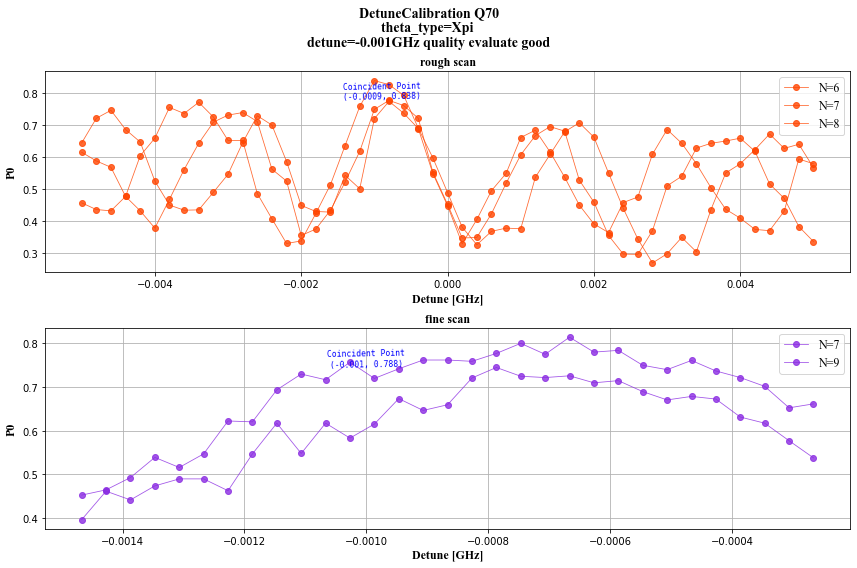

In [34]:
dec.analysis.drawer.figure

In [55]:
qubit.XYwave.detune_pi = -0.707
qubit.XYwave.detune_pi2 = -0.707
pyqlog.info(f'Update {qubit} detune_pi {qubit.XYwave.detune_pi}MHz!')
qubit.save_data()

2022-12-23 01:00:57 |   INFO   | Update Qubit(bit=70) detune_pi -0.707MHz!
2022-12-23 01:00:57 |  UPDATE  | Save q70 to data service success.


In [64]:
dec.analysis.quality

'evaluate good'

In [73]:
dec.analysis.results.detune.value

-0.001

### 更新比特参数信息

In [45]:
detune_pi = dec.analysis.results.detune.value * 1e3
if 'evaluate bad' in dec.analysis.quality:
    qubit.XYwave.detune_pi = detune_pi
    qubit.XYwave.detune_pi2 = detune_pi
    pyqlog.info(f'Update {qubit} detune_pi {qubit.XYwave.detune_pi}MHz!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-11-24 01:18:01 |   INFO   | Update Qubit(bit=70) detune_pi -1.0MHz!
2022-11-24 01:18:01 |  UPDATE  | Save q70 to data service success.


### 检索比特信息

In [57]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'XYwave', 'sample_width']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7056.664,MHz,None
1,probe_power,-32.000,db,None
2,drive_freq,4623.996,MHz,None
3,drive_power,-10.000,db,None
4,XYwave.Xpi,0.860,v,None
5,XYwave.Xpi2,0.430,v,None
6,XYwave.Ypi,NaN,v,None
7,XYwave.Ypi2,NaN,v,None
8,XYwave.Zpi,NaN,v,None
9,XYwave.baseband_freq,566.667,MHz,None


In [59]:
(4738.5-4639.9)*2

197.20000000000073

In [133]:
qubit.XYwave.delta = -197.2
qubit.XYwave.alpha = 0.5
qubit.save_data()

2022-12-15 16:40:53 |  UPDATE  | Save q68 to data service success.


In [62]:
qubit.XYwave.alpha

1

## AmpOptimize

幅值优化实验，改实验通过微调 X 门驱动幅值，精细校准 X 门幅值

2022-12-23 00:59:03 |   EXP    | theta_type: Xpi, N: 5
2022-12-23 00:59:07 |   EXP    | AmpOptimize register success, id 63a48cdbcb15ce0ce2c761f3
2022-12-23 00:59:07 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\AmpOptimize\q70\2022-12-23\00.59.03\


<IPython.core.display.Javascript object>


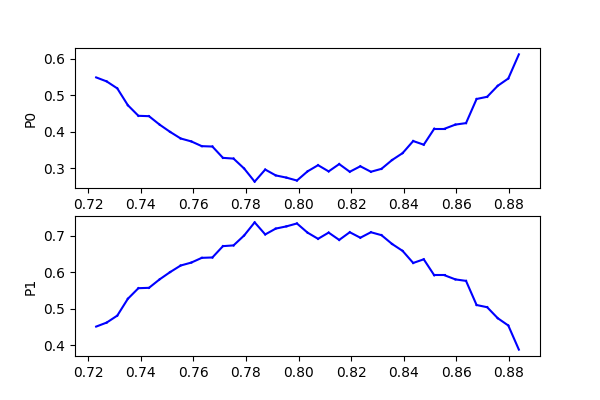

  0%|          | 0/41 [00:00<?, ?it/s]

2022-12-23 00:59:36 |  RESULT  | Experiment results as follow:
| name | describe | value  | unit |      quality      | 
-------------------------------------------------------
| Xpi  |  X-amp   | 0.8034 |  V   | R²=0.9763(normal) | 


In [52]:
ao = AmpOptimize.from_experiment_context(context)
ao.set_experiment_options(
    ac_prepare_time=10000,
    theta_type="Xpi", N=5,
    points=41,
#     threshold_left = 0.8,
#     threshold_right = 1.2
#     simulator_data_path='../scripts/simulator/data/AmpOptimize/'
)

ao.run()

### 查询脉冲时序图

In [ ]:
ao.jupyter_schedule()

### 查询实验结果

In [159]:
pd.DataFrame(ao.analysis.show_results())

,name,value,unit,extra,quality
0,X-amp,0.82,V,{},R²=0.9697(normal)


### 查询实验结果图

In [ ]:
ao.analysis.drawer.figure

### 更新比特参数

In [50]:
ao_quality = ao.analysis.quality.descriptor
Xpi = ao.analysis.results.Xpi.value

if ao_quality == Quality.perfect:
    qubit.XYwave.Xpi = Xpi
    pyqlog.info(f'Update {qubit} Xpi {qubit.XYwave.Xpi}V!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-23 00:57:53 |   INFO   | Update Qubit(bit=70) Xpi 0.8034V!
2022-12-23 00:57:53 |  UPDATE  | Save q70 to data service success.


In [48]:
qubit.XYwave.Xpi = 0.70
qubit.save_data()

2022-12-09 18:21:48 |  UPDATE  | Save q70 to data service success.


In [ ]:
# ao_quality = ao.analysis.quality.descriptor
# Xpi2 = ao.analysis.results.Xpi2.value

# if ao_quality == Quality.perfect:
#     qubit.XYwave.Xpi2 = Xpi2
#     pyqlog.info(f'Update {qubit} Xpi2 {qubit.XYwave.Xpi2}V!')
#     qubit.save_data()
# else:
#     pyqlog.info(f'Experiment results bad, please check!')

### 检索比特参数

In [161]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'sample_width', 'XYwave']
    )
)

,parameter,value,unit,update_time
0,probe_freq,7126.303,MHz,None
1,probe_power,-28.000,db,None
2,drive_freq,4796.587,MHz,None
3,drive_power,-10.000,db,None
4,sample_width,1000.000,ns,None
5,XYwave.Xpi,0.820,v,None
6,XYwave.Xpi2,0.410,v,None
7,XYwave.Ypi,NaN,v,None
8,XYwave.Ypi2,NaN,v,None
9,XYwave.Zpi,NaN,v,None


## T1

测量比特纵向退相干时间 `T1`

2022-12-23 00:46:04 |   EXP    | T1 register success, id 63a489cccb15ce0ce2c75fec
2022-12-23 00:46:04 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\T1\q70\2022-12-23\00.45.57\


<IPython.core.display.Javascript object>


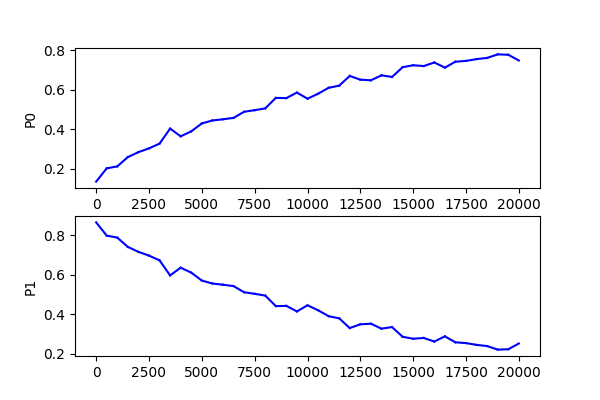

  0%|          | 0/41 [00:00<?, ?it/s]

2022-12-23 00:46:33 |  RESULT  | Experiment results as follow:
| name | describe |  value  | unit |      quality       | 
---------------------------------------------------------
| tau  |    T1    | 12.6153 |  us  | R²=0.9914(perfect) | 
| rate |   rate   |  0.631  | None | R²=0.9914(perfect) | 


In [38]:
t1_exp = T1.from_experiment_context(context)
t1_exp.set_experiment_options(
    ac_prepare_time=10000,
    z_amp=0.01,
    delay_list=qarange(0, 20000, 500),
#     simulator_data_path='../scripts/simulator/data/T1/'
)

t1_exp.run()

### 查看实验结果

In [ ]:
pd.DataFrame(t1_exp.analysis.show_results())

### 查看实验脉冲时序图

In [ ]:
t1_exp.jupyter_schedule()

### 查看实验结果图

In [ ]:
t1_exp.analysis.drawer.figure

### 更新比特参数

In [ ]:
t1_quality = t1_exp.analysis.quality.descriptor
t1 = t1_exp.analysis.results.tau.value * 1e3

if t1_quality == Quality.perfect:
    qubit.T1 = t1
    pyqlog.info(f'Update {qubit} T1 {qubit.T1}ns!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

In [ ]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=['probe_freq', 'probe_power', 'drive_freq', 'drive_power', 'sample_width', 'XYwave', 'T1']
    )
)

## T2

测量比特横向退相干时间 `T2`

2022-12-23 00:48:15 |   EXP    | rate_down: 0.3, rate_up: 0.5, max_loops: 1
2022-12-23 00:48:15 |   EXP    | T2Ramsey count: 0, z_amp: None v, fringe: 574.667 MHz
2022-12-23 00:48:26 |   EXP    | Ramsey register success, id 63a48a5acb15ce0ce2c76054
2022-12-23 00:48:26 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\T2Ramsey\q70\2022-12-23\00.48.15\Ramsey\00-48-15-count=0-z_amp=None-fringe=574.667\


<IPython.core.display.Javascript object>


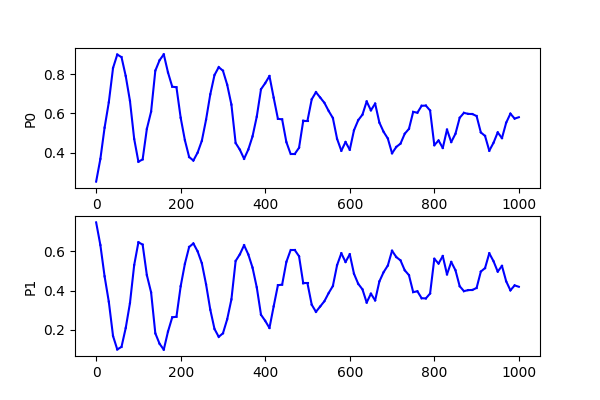

  0%|          | 0/101 [00:00<?, ?it/s]

2022-12-23 00:49:32 |  RESULT  | Experiment results as follow:
|  name   | describe |     value     | unit |       quality       | 
-------------------------------------------------------------------
|   tau   |  T2star  | 0.65928634064 |  us  | R²=0.8295(abnormal) | 
|  freq   |   fosc   |    8.39847    | MHz  | R²=0.8295(abnormal) | 
| t2_rate | t2_rate  | 0.65928634064 | None | R²=0.8295(abnormal) | 


In [39]:
t2_exp = T2Ramsey.from_experiment_context(context)
t2_exp.set_experiment_options(
    
    delays=qarange(0, 1000,10 ),
    fringe=566.667 + 8,
    max_loops=1
#     simulator_data_path='../scripts/simulator/data/T2/'
)

t2_exp.child_experiment.set_experiment_options(ac_prepare_time=8000,)

t2_exp.run()

### 查询实验结果

In [170]:
pd.DataFrame(t2_exp.analysis.show_results())

,name,value,unit,extra,quality
0,T2star,8.051146,us,{},R²=0.9599(normal)
1,fosc,1.015510,MHz,{},R²=0.9599(normal)
2,t2_rate,0.619319,None,{},R²=0.9599(normal)


### 查询实验脉冲时序图

In [ ]:
t2_exp.jupyter_schedule()

### 查询实验结果图

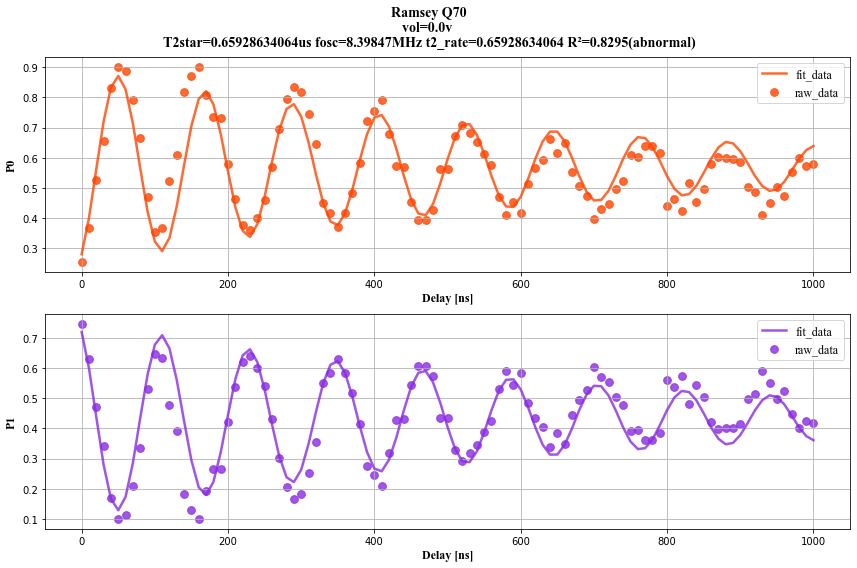

In [40]:
t2_exp.analysis.drawer.figure

### 更新比特参数

In [173]:
t2 = t2_exp.analysis.results.tau.value * 1e3
qubit.T2 = t2
pyqlog.info(f'Update {qubit} T2 {qubit.T2}ns!')
qubit.save_data()

2022-11-21 21:34:22 |   INFO   | Update Qubit(bit=70) T2 8051.14619389ns!
2022-11-21 21:34:22 |  UPDATE  | Save q70 to data service success.


In [176]:
t2_quality = t2_exp.analysis.quality.descriptor
t2 = t2_exp.analysis.results.tau.value * 1e3

if t2_quality == Quality.normal:
    qubit.T2 = t2
    pyqlog.info(f'Update {qubit} T2 {qubit.T2}ns!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-11-21 21:35:30 |   INFO   | Update Qubit(bit=70) T2 8051.14619389ns!
2022-11-21 21:35:30 |  UPDATE  | Save q70 to data service success.


### 检索比特参数

In [ ]:
pd.DataFrame(
    context.base_qubit_table(
        context.qubit,
        parameters=[
            'probe_freq', 'probe_power', 'drive_freq', 'drive_power', 
            'sample_width', 'XYwave', 'T1', 'T2']
    )
)

## RB

`Randomized Benchmarking` 来标定单量子比特门保真度

In [61]:
rb_exp = RBSingle.from_experiment_context(context)
rb_exp.set_experiment_options(
    ac_prepare_time=8000,
    depths=np.hstack(
        [
            np.arange(2, 10, 2),
            np.arange(10, 50, 5),
            np.arange(50, 100, 10),
#             np.arange(100, 200, 20)
        ]
    ).tolist(),
    times=30,
    gate_split=False,
#     simulator_data_path='../scripts/simulator/data/RB/',
    schedule_index=[0]
)

rb_exp.run()

MemoryError: Unable to allocate 3.27 MiB for an array with shape (9, 47601) and data type float64

### 查询脉冲时序图

In [ ]:
rb_exp.jupyter_schedule()

### 查询实验结果

In [ ]:
pd.DataFrame(rb_exp.analysis.show_results())

### 查询实验结果图

In [ ]:
rb_exp.analysis.drawer.figure

## QPT

`Quantum Process Tomography` 来标定单量子比特门保真度

In [7]:
qpt_exp = ProcessTomography.from_experiment_context(context)

# simulator_data_path = '../scripts/simulator/data/ProcessTomography/SingleQubit/IGate/'

qpt_exp.set_experiment_options(
    goal_gate='X',
    qubit_nums=1,
#     simulator_data_path=simulator_data_path,
    show_result=True
)
qpt_exp.set_analysis_options(use_mle=True)

qpt_exp.run()

2022-12-01 16:22:25 |   EXP    | StateTomography register success, id 63886441123979c2bc335a4f
2022-12-01 16:22:25 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ProcessTomography\q70\2022-12-01\16.22.24\StateTomography\16-22-24-['I']\


  0%|          | 0/3 [00:00<?, ?it/s]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3 and the array at index 1 has size 1000

### 查询实验结果

In [184]:
pd.DataFrame(qpt_exp.analysis.show_results())

,name,value,unit,extra,quality
0,exp_chi_matrix,"[[(0.9706715540290267+0j), (-0.004903478726626465+0.0013889376238252172j), (0.0038213824260574275+0.02152924865007118j), (0.01150322537775094+0.01029832072806378j)], [(-0.004903478726626465-0.0013889376238252172j), (0.009051535695919558+0j), (0.003639700967113148-0.011479599597458354j), (0.0022044612493094438+0.0038328322790318493j)], [(0.0038213824260574275-0.02152924865007118j), (0.003639700967113148+0.011479599597458354j), (0.01739622151458492+0j), (-0.004133717366386706+0.004872321193665304j)], [(0.01150322537775094-0.01029832072806378j), (0.0022044612493094438-0.0038328322790318493j), (-0.004133717366386706-0.004872321193665304j), (0.003049606626317272+0j)]]",None,{},None
1,ideal_chi_matrix,"[[(1.0000000000000004+8.896076791452605e-17j), (-3.691512718008711e-16-1.6987262336050975e-16j), (-1.7034584494356492e-16+1.9313783985913177e-16j), (2.683038976177461e-16+2.5110201167889545e-16j)], [(3.5168909705432314e-16+9.364043526578366e-17j), (-1.2601442290656783e-16+2.774675023637665e-17j), (2.868624899295446e-16-6.81859201523387e-16j), (-3.6995586895202886e-16-4.135709452965771e-17j)], [(-1.2805663994388442e-16+3.6277826960460415e-16j), (2.66414084600553e-16-5.39386125564285e-16j), (-1.2601442290656744e-16-4.819515556536797e-17j), (1.8033998068001015e-16-4.698889988642635e-16j)], [(-5.088522196198632e-16-3.1816568570081174e-16j), (1.5820466489607833e-16+1.416984842921471e-16j), (1.9851998401192817e-16-2.7870694560655994e-16j), (1.5728159515523054e-16-2.1897093892609826e-17j)]]",None,{},None
2,fidelity,98.523,%,{},None
3,process_fidelity,97.051,%,{},None


### 查询实验结果图

In [ ]:
qpt_exp.analysis.drawer.figure

### 查询子实验结果图

In [ ]:
qpt_exp.component_experiment(index=3).analysis.drawer.figure

In [ ]:
## 查询数据库中最新的比特信息 

pd.DataFrame(context.base_qubit_table(context.get_qubit(qubit.name)))

## ACSpectrum

In [150]:
ACS_exp = ACSpectrum.from_experiment_context(context)
ACS_exp.set_experiment_options(
    z_amps=qarange(0, 0.12, 0.001),
    delays = qarange(80, 160, 2.5),
    init_fringe = 80,
    osc_freq_limit = 50,
    freq_bound = 4000,
#     simulator_data_path='../scripts/simulator/data/ACSpectrum/'
)
ACS_exp.child_experiment.set_experiment_options(
    ac_prepare_time=8000,
    is_dynamic=False,
    repeat=700)

ACS_exp.run()

2022-12-15 16:56:45 |   EXP    | z_amp = 0.0v, fringe = 486.66700000000003MHz
2022-12-15 16:56:55 |   EXP    | Ramsey register success, id 639ae156f47baa0f116d9f52
2022-12-15 16:56:55 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\16-56-45-z_amp=0.0\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 16:57:19 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality       | 
----------------------------------------------------------------
|   freq    |   fosc    | 79.83006 | MHz  | R²=0.9966(perfect) | 
| stft_flag | stft_flag |   True   | None | R²=0.9966(perfect) | 
2022-12-15 16:57:19 |  RESULT  | osc_freq: 79.83006, new f10: 4624.13594
2022-12-15 16:57:19 |   INFO   | z_amp=0.0 qubit freq = 4624.13594MHz
2022-12-15 16:57:19 |   EXP    | z_amp = 0.001v, fringe = 486.66700000000003MHz
2022-12-15 16:57:29 |   EXP    | Ramsey register success, id 639ae179f47baa0f116d9fc9
2022-12-15 16:57:29 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\16-57-19-z_amp=0.001\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 16:58:18 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality       | 
----------------------------------------------------------------
|   freq    |   fosc    | 71.72276 | MHz  | R²=0.9945(perfect) | 
| stft_flag | stft_flag |   True   | None | R²=0.9945(perfect) | 
2022-12-15 16:58:18 |  RESULT  | osc_freq: 71.72276, new f10: 4632.243240000001
2022-12-15 16:58:18 |   INFO   | z_amp=0.001 qubit freq = 4632.243240000001MHz
2022-12-15 16:58:18 |   EXP    | z_amp = 0.002v, fringe = 486.66700000000003MHz
2022-12-15 16:58:28 |   EXP    | Ramsey register success, id 639ae1b4f47baa0f116da040
2022-12-15 16:58:28 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\16-58-18-z_amp=0.002\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 16:58:53 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality       | 
----------------------------------------------------------------
|   freq    |   fosc    | 63.93536 | MHz  | R²=0.9947(perfect) | 
| stft_flag | stft_flag |   True   | None | R²=0.9947(perfect) | 
2022-12-15 16:58:53 |  RESULT  | osc_freq: 63.93536, new f10: 4640.03064
2022-12-15 16:58:53 |   INFO   | z_amp=0.002 qubit freq = 4640.03064MHz
2022-12-15 16:58:53 |   EXP    | z_amp = 0.003v, fringe = 463.13486000000285MHz
2022-12-15 16:59:03 |   EXP    | Ramsey register success, id 639ae1d7f47baa0f116da0b7
2022-12-15 16:59:03 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\16-58-53-z_amp=0.003\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 16:59:28 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality      | 
---------------------------------------------------------------
|   freq    |   fosc    | 79.75747 | MHz  | R²=0.997(perfect) | 
| stft_flag | stft_flag |   True   | None | R²=0.997(perfect) | 
2022-12-15 16:59:28 |  RESULT  | osc_freq: 79.75747, new f10: 4647.740669999998
2022-12-15 16:59:28 |   INFO   | z_amp=0.003 qubit freq = 4647.740669999998MHz
2022-12-15 16:59:28 |   EXP    | z_amp = 0.004v, fringe = 455.2596700000049MHz
2022-12-15 16:59:38 |   EXP    | Ramsey register success, id 639ae1faf47baa0f116da12e
2022-12-15 16:59:38 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\16-59-28-z_amp=0.004\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:00:30 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality      | 
---------------------------------------------------------------
|   freq    |   fosc    | 79.97853 | MHz  | R²=0.994(perfect) | 
| stft_flag | stft_flag |   True   | None | R²=0.994(perfect) | 
2022-12-15 17:00:30 |  RESULT  | osc_freq: 79.97853, new f10: 4655.3947999999955
2022-12-15 17:00:30 |   INFO   | z_amp=0.004 qubit freq = 4655.3947999999955MHz
2022-12-15 17:00:30 |   EXP    | z_amp = 0.005v, fringe = 447.63997000000927MHz
2022-12-15 17:00:40 |   EXP    | Ramsey register success, id 639ae238f47baa0f116da1a5
2022-12-15 17:00:40 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-00-30-z_amp=0.005\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:01:29 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality       | 
----------------------------------------------------------------
|   freq    |   fosc    | 79.83365 | MHz  | R²=0.9962(perfect) | 
| stft_flag | stft_flag |   True   | None | R²=0.9962(perfect) | 
2022-12-15 17:01:29 |  RESULT  | osc_freq: 79.83365, new f10: 4663.159379999992
2022-12-15 17:01:29 |   INFO   | z_amp=0.005 qubit freq = 4663.159379999992MHz
2022-12-15 17:01:29 |   EXP    | z_amp = 0.006v, fringe = 439.59859000001325MHz
2022-12-15 17:01:39 |   EXP    | Ramsey register success, id 639ae273f47baa0f116da21c
2022-12-15 17:01:39 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-01-29-z_amp=0.006\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:02:04 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality       | 
----------------------------------------------------------------
|   freq    |   fosc    | 81.07376 | MHz  | R²=0.9862(perfect) | 
| stft_flag | stft_flag |   True   | None | R²=0.9862(perfect) | 
2022-12-15 17:02:04 |  RESULT  | osc_freq: 81.07376, new f10: 4669.960649999987
2022-12-15 17:02:04 |   INFO   | z_amp=0.006 qubit freq = 4669.960649999987MHz
2022-12-15 17:02:04 |   EXP    | z_amp = 0.007v, fringe = 434.8343900000191MHz
2022-12-15 17:02:14 |   EXP    | Ramsey register success, id 639ae296f47baa0f116da293
2022-12-15 17:02:14 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-02-04-z_amp=0.007\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:02:38 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality       | 
----------------------------------------------------------------
|   freq    |   fosc    | 78.91872 | MHz  | R²=0.9839(perfect) | 
| stft_flag | stft_flag |   True   | None | R²=0.9839(perfect) | 
2022-12-15 17:02:39 |  RESULT  | osc_freq: 78.91872, new f10: 4676.879889999982
2022-12-15 17:02:39 |   INFO   | z_amp=0.007 qubit freq = 4676.879889999982MHz
2022-12-15 17:02:39 |   EXP    | z_amp = 0.008v, fringe = 426.7159000000247MHz
2022-12-15 17:02:48 |   EXP    | Ramsey register success, id 639ae2b8f47baa0f116da30a
2022-12-15 17:02:48 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-02-39-z_amp=0.008\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:03:14 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality      | 
---------------------------------------------------------------
|   freq    |   fosc    | 81.85977 | MHz  | R²=0.9516(normal) | 
| stft_flag | stft_flag |   True   | None | R²=0.9516(normal) | 
2022-12-15 17:03:14 |  RESULT  | osc_freq: 81.85977, new f10: 4682.057329999976
2022-12-15 17:03:14 |   INFO   | z_amp=0.008 qubit freq = 4682.057329999976MHz
2022-12-15 17:03:14 |   EXP    | z_amp = 0.009v, fringe = 425.1400300000323MHz
2022-12-15 17:03:23 |   EXP    | Ramsey register success, id 639ae2dbf47baa0f116da381
2022-12-15 17:03:23 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-03-14-z_amp=0.009\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:04:18 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |      quality      | 
---------------------------------------------------------------
|   freq    |   fosc    | 75.32292 | MHz  | R²=0.9651(normal) | 
| stft_flag | stft_flag |   True   | None | R²=0.9651(normal) | 
2022-12-15 17:04:19 |  RESULT  | osc_freq: 75.32292, new f10: 4690.170049999969
2022-12-15 17:04:19 |   INFO   | z_amp=0.009 qubit freq = 4690.170049999969MHz
2022-12-15 17:04:19 |   EXP    | z_amp = 0.01v, fringe = 409.41495000004033MHz
2022-12-15 17:04:29 |   EXP    | Ramsey register success, id 639ae31cf47baa0f116da3f8
2022-12-15 17:04:29 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-04-19-z_amp=0.01\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:05:35 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |       quality       | 
-----------------------------------------------------------------
|   freq    |   fosc    | 85.62567 | MHz  | R²=0.9176(abnormal) | 
| stft_flag | stft_flag |   True   | None | R²=0.9176(abnormal) | 
2022-12-15 17:05:35 |  RESULT  | osc_freq: 85.62567, new f10: 4695.59237999996
2022-12-15 17:05:35 |   INFO   | z_amp=0.01 qubit freq = 4695.59237999996MHz
2022-12-15 17:05:35 |   EXP    | z_amp = 0.011v, fringe = 412.308680000051MHz
2022-12-15 17:05:45 |   EXP    | Ramsey register success, id 639ae369f47baa0f116da46f
2022-12-15 17:05:45 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-05-35-z_amp=0.011\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:06:51 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |       quality       | 
-----------------------------------------------------------------
|   freq    |   fosc    | 77.00809 | MHz  | R²=0.8659(abnormal) | 
| stft_flag | stft_flag |   True   | None | R²=0.8659(abnormal) | 
2022-12-15 17:06:51 |  RESULT  | osc_freq: 77.00809, new f10: 4701.316229999949
2022-12-15 17:06:51 |   INFO   | z_amp=0.011 qubit freq = 4701.316229999949MHz
2022-12-15 17:06:51 |   EXP    | z_amp = 0.012v, fringe = 403.29140000006373MHz
2022-12-15 17:07:01 |   EXP    | Ramsey register success, id 639ae3b5f47baa0f116da4e6
2022-12-15 17:07:01 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-06-51-z_amp=0.012\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:07:26 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |    quality     | 
------------------------------------------------------------
|   freq    |   fosc    | 82.26601 | MHz  | R²=0.6353(bad) | 
| stft_flag | stft_flag |   True   | None | R²=0.6353(bad) | 
2022-12-15 17:07:26 |  RESULT  | osc_freq: 82.26601, new f10: 4705.075589999937
2022-12-15 17:07:26 |   INFO   | z_amp=0.012 qubit freq = 4705.075589999937MHz
2022-12-15 17:07:26 |   EXP    | z_amp = 0.013v, fringe = 403.76254000007884MHz
2022-12-15 17:07:36 |   EXP    | Ramsey register success, id 639ae3d8f47baa0f116da55d
2022-12-15 17:07:36 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-07-26-z_amp=0.013\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:08:01 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |    quality     | 
------------------------------------------------------------
|   freq    |   fosc    | 75.62585 | MHz  | R²=0.6072(bad) | 
| stft_flag | stft_flag |   True   | None | R²=0.6072(bad) | 
2022-12-15 17:08:01 |  RESULT  | osc_freq: 75.62585, new f10: 4711.2446099999215
2022-12-15 17:08:01 |   INFO   | z_amp=0.013 qubit freq = 4711.2446099999215MHz
2022-12-15 17:08:01 |   EXP    | z_amp = 0.014v, fringe = 390.80971000009686MHz
2022-12-15 17:08:11 |   EXP    | Ramsey register success, id 639ae3faf47baa0f116da5d4
2022-12-15 17:08:11 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-08-01-z_amp=0.014\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:08:35 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |    quality    | 
-----------------------------------------------------------
|   freq    |   fosc    | 86.01823 | MHz  | R²=0.481(bad) | 
| stft_flag | stft_flag |  False   | None | R²=0.481(bad) | 
2022-12-15 17:08:35 |  RESULT  | osc_freq: 86.01823, new f10: 4713.805059999904
2022-12-15 17:08:35 |   INFO   | z_amp=0.014 qubit freq = 4713.805059999904MHz
2022-12-15 17:08:35 |   EXP    | z_amp = 0.015v, fringe = 397.876060000116MHz
2022-12-15 17:08:45 |   EXP    | Ramsey register success, id 639ae41df47baa0f116da64b
2022-12-15 17:08:45 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-08-35-z_amp=0.015\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:09:10 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |    quality    | 
-----------------------------------------------------------
|   freq    |   fosc    | 70.47469 | MHz  | R²=0.611(bad) | 
| stft_flag | stft_flag |   True   | None | R²=0.611(bad) | 
2022-12-15 17:09:10 |  RESULT  | osc_freq: 70.47469, new f10: 4722.282249999885
2022-12-15 17:09:10 |   INFO   | z_amp=0.015 qubit freq = 4722.282249999885MHz
2022-12-15 17:09:10 |   EXP    | z_amp = 0.016v, fringe = 373.95682000013767MHz
2022-12-15 17:09:20 |   EXP    | Ramsey register success, id 639ae440f47baa0f116da6c2
2022-12-15 17:09:20 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-09-10-z_amp=0.016\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:10:27 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value  | unit |    quality    | 
----------------------------------------------------------
|   freq    |   fosc    | 93.7643 | MHz  | R²=0.362(bad) | 
| stft_flag | stft_flag |  False  | None | R²=0.362(bad) | 
2022-12-15 17:10:27 |  RESULT  | osc_freq: 93.7643, new f10: 4722.911879999863
2022-12-15 17:10:27 |   INFO   | z_amp=0.016 qubit freq = 4722.911879999863MHz
2022-12-15 17:10:27 |   EXP    | z_amp = 0.017v, fringe = 394.93905000016184MHz
2022-12-15 17:10:36 |   EXP    | Ramsey register success, id 639ae48cf47baa0f116da739
2022-12-15 17:10:36 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-10-27-z_amp=0.017\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:11:01 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |    quality     | 
------------------------------------------------------------
|   freq    |   fosc    | 70.55565 | MHz  | R²=0.4387(bad) | 
| stft_flag | stft_flag |  False   | None | R²=0.4387(bad) | 
2022-12-15 17:11:01 |  RESULT  | osc_freq: 70.55565, new f10: 4725.138299999839
2022-12-15 17:11:01 |   INFO   | z_amp=0.017 qubit freq = 4725.138299999839MHz
2022-12-15 17:11:01 |   EXP    | z_amp = 0.018v, fringe = 381.6714900001907MHz
2022-12-15 17:11:11 |   EXP    | Ramsey register success, id 639ae4aff47baa0f116da7b0
2022-12-15 17:11:11 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-11-01-z_amp=0.018\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:11:36 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |    quality     | 
------------------------------------------------------------
|   freq    |   fosc    | 24.88042 | MHz  | R²=0.2683(bad) | 
| stft_flag | stft_flag |  False   | None | R²=0.2683(bad) | 
2022-12-15 17:11:36 |  RESULT  | osc_freq: 24.88042, new f10: 4784.08108999981
2022-12-15 17:11:36 |  ERROR   | osc freq=24.88042MHz is not excepted!
2022-12-15 17:11:36 |   EXP    | z_amp = 0.019v, fringe = 376.25149000022157MHz
2022-12-15 17:11:46 |   EXP    | Ramsey register success, id 639ae4d2f47baa0f116da827
2022-12-15 17:11:46 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-11-36-z_amp=0.019\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:12:11 |  RESULT  | Experiment results as follow:
|   name    | describe  |  value   | unit |    quality     | 
------------------------------------------------------------
|   freq    |   fosc    | 77.43288 | MHz  | R²=0.3033(bad) | 
| stft_flag | stft_flag |  False   | None | R²=0.3033(bad) | 
2022-12-15 17:12:11 |  RESULT  | osc_freq: 77.43288, new f10: 4736.948629999779
2022-12-15 17:12:11 |   INFO   | z_amp=0.019 qubit freq = 4736.948629999779MHz
2022-12-15 17:12:11 |   EXP    | z_amp = 0.02v, fringe = 321.3119800004488MHz
2022-12-15 17:12:23 |   EXP    | Ramsey register success, id 639ae4f7f47baa0f116da89e
2022-12-15 17:12:23 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-12-11-z_amp=0.02\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:12:48 |  RESULT  | Experiment results as follow:
|   name    | describe  |   value   | unit |    quality     | 
-------------------------------------------------------------
|   freq    |   fosc    | 133.86635 | MHz  | R²=0.3446(bad) | 
| stft_flag | stft_flag |   False   | None | R²=0.3446(bad) | 
2022-12-15 17:12:48 |  RESULT  | osc_freq: 133.86635, new f10: 4735.454669999552
2022-12-15 17:12:48 |  ERROR   | osc freq=133.86635MHz is not excepted!
2022-12-15 17:12:48 |   EXP    | z_amp = 0.021v, fringe = 280.7499200006141MHz
2022-12-15 17:12:58 |   EXP    | Ramsey register success, id 639ae519f47baa0f116da915
2022-12-15 17:12:58 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-12-48-z_amp=0.021\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:13:22 |  RESULT  | Experiment results as follow:
|   name    | describe  |   value   | unit |    quality     | 
-------------------------------------------------------------
|   freq    |   fosc    | 168.03981 | MHz  | R²=0.4729(bad) | 
| stft_flag | stft_flag |   False   | None | R²=0.4729(bad) | 
2022-12-15 17:13:22 |  RESULT  | osc_freq: 168.03981, new f10: 4741.843269999386
2022-12-15 17:13:22 |  ERROR   | osc freq=168.03981MHz is not excepted!
2022-12-15 17:13:22 |   EXP    | z_amp = 0.022v, fringe = 230.60395000081644MHz
2022-12-15 17:13:32 |   EXP    | Ramsey register success, id 639ae53cf47baa0f116da98c
2022-12-15 17:13:32 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ACSpectrum\q68\2022-12-15\16.56.45\Ramsey\17-13-22-z_amp=0.022\


  0%|          | 0/33 [00:00<?, ?it/s]

2022-12-15 17:13:57 |  RESULT  | Experiment results as follow:
|   name    | describe  |   value   | unit |    quality     | 
-------------------------------------------------------------
|   freq    |   fosc    | 183.97102 | MHz  | R²=0.2666(bad) | 
| stft_flag | stft_flag |   False   | None | R²=0.2666(bad) | 
2022-12-15 17:13:57 |  RESULT  | osc_freq: 183.97102, new f10: 4776.058029999184
2022-12-15 17:13:57 |  ERROR   | osc freq=183.97102MHz is not excepted!
2022-12-15 17:13:57 |  RESULT  | Experiment results as follow:
|  name  | describe |     value      | unit |      quality       | 
------------------------------------------------------------------
| fq_max |  fq_max  | 4768.96305484  | None | R²=0.9988(perfect) | 
| detune |  detune  | -4539.64032795 | None | R²=0.9988(perfect) | 
|   M    |    M     |  12.20051167   | None | R²=0.9988(perfect) | 
| offset |  offset  |   0.03885152   | None | R²=0.9988(perfect) | 
|   d    |    d     |  -0.10958712   | None | R²=0.9988(perfect

### 查询实验结果

In [20]:
pd.DataFrame(ACS_exp.analysis.show_results())

,name,value,unit,extra,quality
0,fq_max,4795.972473,None,{},R²=1.0(perfect)
1,detune,-2017.539422,None,{},R²=1.0(perfect)
2,M,4.565931,None,{},R²=1.0(perfect)
3,offset,-0.000625,None,{},R²=1.0(perfect)
4,d,0.180620,None,{},R²=1.0(perfect)


In [46]:
ACS_exp.analysis.show_results()['value']

[4795.9724735, -2017.53942185, 4.56593141, -0.00062481, 0.18062012]

### 查询实验结果图

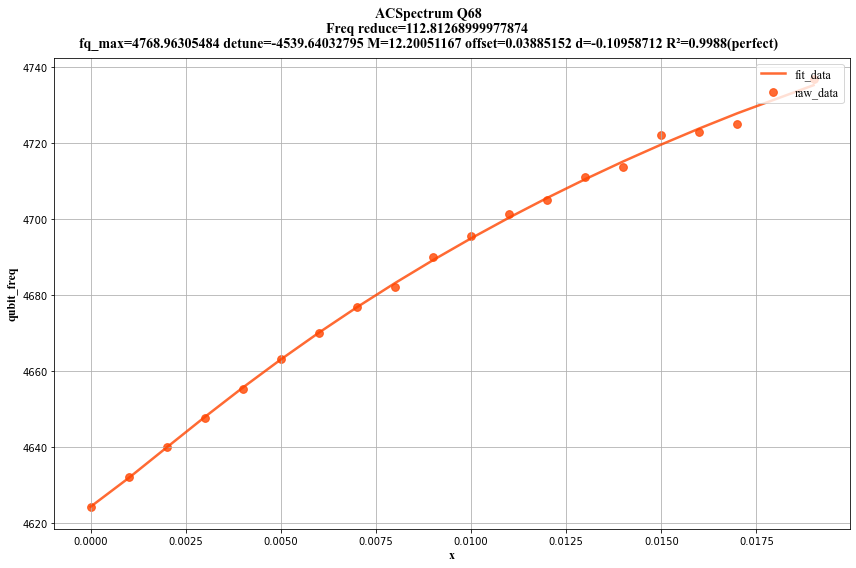

In [151]:
ACS_exp.analysis.drawer.figure

### 更新AC谱参数

In [60]:
from pyQCat.invoker import DataCenter
ACS_paras = ACS_exp.analysis.show_results()['value']
ACS_exp_quality = ACS_exp.analysis.quality.descriptor

if ACS_exp_quality == Quality.perfect:
    db = DataCenter()
    filename = 'character.json'
    data = db.query_config(filename)['data'][0]['json']
    data[q_name_list[0]]['frequency_zamp_fitting'] = ACS_paras  # z_delay
    db.update_single_config(filename, data)
    
    qubit.ac_spectrum.standard = ACS_paras
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-11-22 20:52:55 |  UPDATE  | Save q70 to data service success.


In [52]:
qubit.ac_spectrum.standard

[4795.9724735, -2017.53942185, 4.56593141, -0.00062481, 0.18062012]

## T1Spectrum

In [ ]:
T1S_exp = T1Spectrum.from_experiment_context(context)
T1S_exp.set_experiment_options(
    z_amp_list = qarange(-0.07, 0.07, 0.001),
    delay_list = qarange(0, 30000, 300),

#     simulator_data_path='../scripts/simulator/data/ACSpectrum/'
)
T1S_exp.child_experiment.set_experiment_options(
    is_dynamic=False,)

T1S_exp.run()

### 查询实验结果

In [20]:
pd.DataFrame(T1S_exp.analysis.show_results())

,name,value,unit,extra,quality
0,fq_max,4795.972473,None,{},R²=1.0(perfect)
1,detune,-2017.539422,None,{},R²=1.0(perfect)
2,M,4.565931,None,{},R²=1.0(perfect)
3,offset,-0.000625,None,{},R²=1.0(perfect)
4,d,0.180620,None,{},R²=1.0(perfect)


In [46]:
ACS_exp.analysis.show_results()['value']

[4795.9724735, -2017.53942185, 4.56593141, -0.00062481, 0.18062012]

### 查询实验结果图

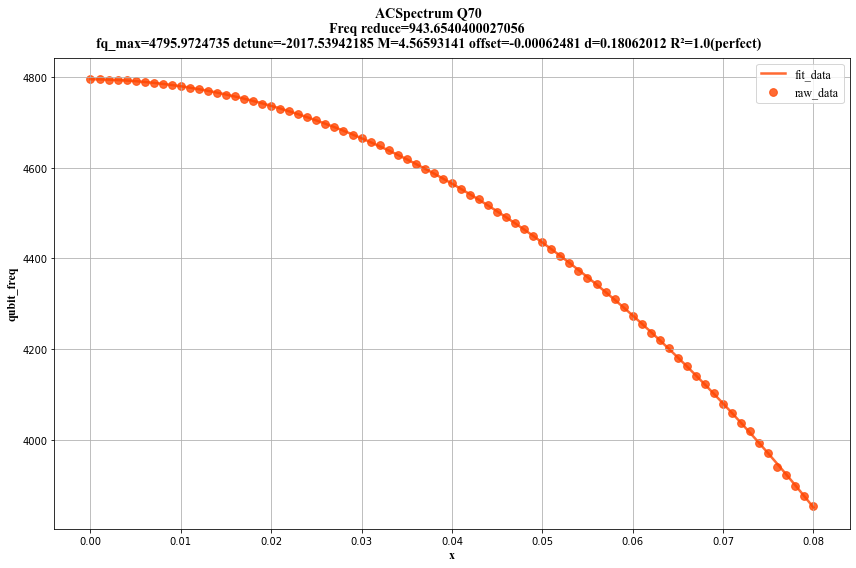

In [21]:
ACS_exp.analysis.drawer.figure

## ACSpectrum

In [ ]:
ACS_exp = ACSpectrum.from_experiment_context(context)
ACS_exp.set_experiment_options(
    z_amps=qarange(0, 0.08, 0.001),
    delays = qarange(80, 160, 2.5),
    init_fringe = 80,
    osc_freq_limit = 50,
    freq_bound = 4000,
#     simulator_data_path='../scripts/simulator/data/ACSpectrum/'
)
ACS_exp.child_experiment.set_experiment_options(
    is_dynamic=False,
    repeat=700)

ACS_exp.run()

### 查询实验结果

In [20]:
pd.DataFrame(ACS_exp.analysis.show_results())

,name,value,unit,extra,quality
0,fq_max,4795.972473,None,{},R²=1.0(perfect)
1,detune,-2017.539422,None,{},R²=1.0(perfect)
2,M,4.565931,None,{},R²=1.0(perfect)
3,offset,-0.000625,None,{},R²=1.0(perfect)
4,d,0.180620,None,{},R²=1.0(perfect)


In [46]:
ACS_exp.analysis.show_results()['value']

[4795.9724735, -2017.53942185, 4.56593141, -0.00062481, 0.18062012]

### 查询实验结果图

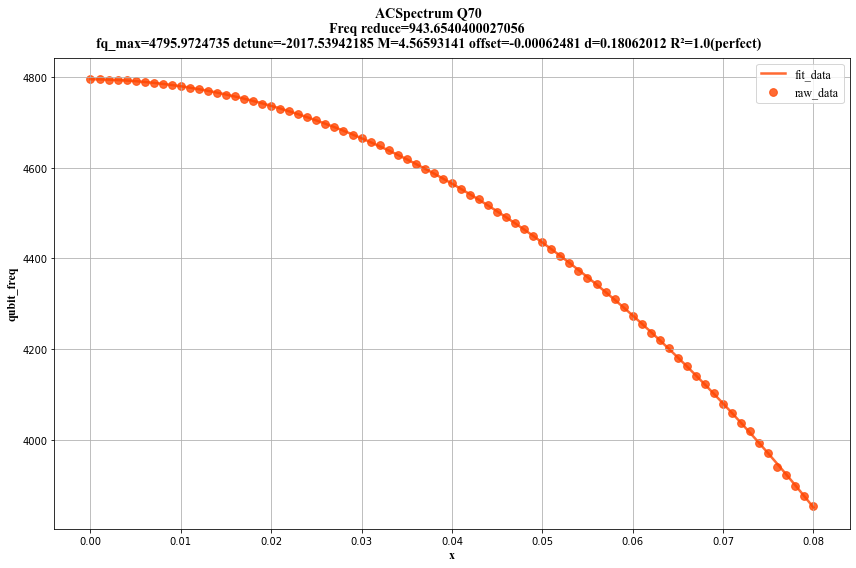

In [21]:
ACS_exp.analysis.drawer.figure

## XYZtiming

2022-12-23 00:50:52 |   EXP    | XYZTiming register success, id 63a48aeccb15ce0ce2c76122
2022-12-23 00:50:52 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\XYZTiming\q70\2022-12-23\00.50.32\


<IPython.core.display.Javascript object>


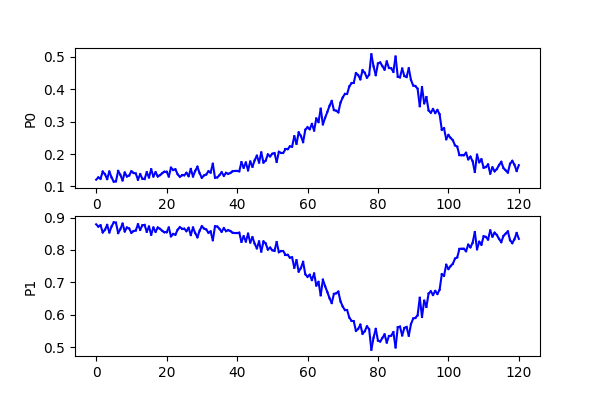

  0%|          | 0/193 [00:00<?, ?it/s]

2022-12-23 00:52:58 |  RESULT  | Experiment results as follow:
| name | describe | value  | unit |      quality       | 
--------------------------------------------------------
|  fr  |  Delay   | 81.875 |  ns  | R²=0.9876(perfect) | 
2022-12-23 00:52:58 |   INFO   | Qubit(bit=70) XYZTiming, delay offset: -31.875
2022-12-23 00:52:58 |   INFO   | The XY line comes after the Z line，so add Z line delay 31.875


-31.875

In [41]:
xyz_exp = XYZTiming.from_experiment_context(context)
xyz_exp.set_experiment_options(
    ac_prepare_time=10000,
    delay_list = qarange(0, 120, 0.625),
    z_amp = 0.07,

#     simulator_data_path='../scripts/simulator/data/ACSpectrum/'
)

xyz_exp.run()






### 查询脉冲时序图

In [ ]:
xyz_exp.jupyter_schedule()

### 查询实验结果

In [53]:
pd.DataFrame(xyz_exp.analysis.show_results())

,name,value,unit,extra,quality
0,Delay,85.0,ns,{},R²=0.9893(perfect)


### 查询实验结果图

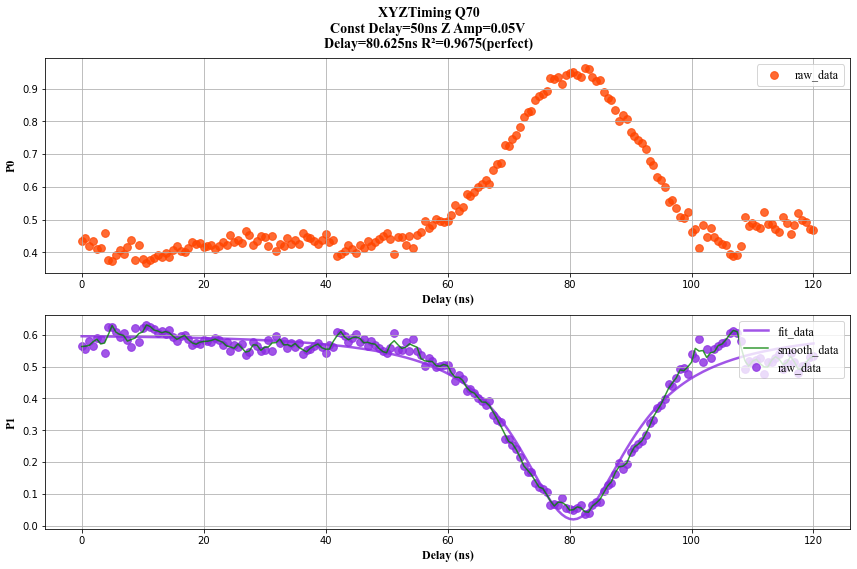

In [60]:
xyz_exp.analysis.drawer.figure

In [54]:
xyz_exp.analysis.results.fr.value

85.0

### 更新比特参数

In [42]:
from pyQCat.invoker import DataCenter

xyz_exp_quality = xyz_exp.analysis.quality.descriptor
Delay = 31.875
if xyz_exp_quality == Quality.perfect:
    db = DataCenter()
    filename = 'character.json'
    data = db.query_config(filename)['data'][0]['json']
    data[q_name]['hardware_offset'][1] = Delay  # z_delay
    db.update_single_config(filename, data)
else:
    pyqlog.info(f'Experiment results bad, please check!')

## DistortionT1

In [37]:
%matplotlib inline

In [11]:
Distortion_exp = DistortionT1Composite.from_experiment_context(context)
Distortion_exp.set_experiment_options(
    iteration_times = 2,
    xy_delay_max = 1000,
    init_step = 1.25,
    z_amp = -0.1,
    z_offset_list = qarange(-0.01, 0.015, 0.0002),

    simulator_data_path='E:\Data\D1\\20221107\\220826-72bit-300pin-V8.2-Base-24#_monster\DistortionT1Composite\q70\\2022-11-23\\00.44.11\DistortionT1/'
)

Distortion_exp.child_experiment.set_experiment_options(
    is_dynamic=0)


Distortion_exp.run()






ValueError: invalid literal for int() with base 10: 'iter0_xy_delay=1'